<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">

# Physics NeMo External Aerodynamics DLI

## Notebook 3 – Using the DoMINO-Automotive-Aero NIM

In this notebook, we explore the practical application of the **DoMINO-Automotive-Aero Neural Inference Model (NIM)** for aerodynamic analysis of road vehicles. This pre-trained model represents a significant advancement in computational fluid dynamics (CFD) simulation, offering a rapid and efficient alternative to traditional RANS simulations.

The model has been trained on an extensive dataset of **1,500 steady-state RANS simulations** of road vehicles with varying geometries, operating at speeds from **20 m/s to 50 m/s**.

We will walk through the steps required to generate a sample model inference on a simulation mesh and to compare the model's predictions with ground-truth data across several metrics relevant to external aerodynamics. This notebook uses the surface results from the [DrivAerML dataset](https://caemldatasets.org/drivaerml/).

Many of the direct imports from ```physicsnemo-cfd``` used below are are now available in the [```physicsnemo-cfd```](https://github.com/NVIDIA/physicsnemo-cfd/tree/main) library!

## Table of Contents

- [NIM Overview](#nim-overview)
- [Understanding the DoMINO-Automotive-Aero NIM](#understanding-the-domino-automotive-aero-nim)
- [Usability Guidelines](#usability-guidelines)
- [Fetching Input Data](#fetching-input-data)
- [Producing a Forecast with the DoMINO-Automotive-Aero NIM](#producing-a-forecast-with-the-domino-automotive-aero-nim)
- [Visualization and Validation](#visualization-and-validation)
- [Confidence Scores and Reliability](#confidence-scores-and-reliability)
- [Bonus: Computing the Equation Residuals](#bonus-computing-the-equation-residuals)

## NIM Overview

The objective of this NIM is to showcase the potential of foundation models in the design of roadside vehicles. It serves as a valuable starting point for:

- **ISV developers**
- **Aerodynamic engineers**
- **Designers**
- **Researchers**

These professionals can use the tool in the early stages of design evaluation. The model also offers capabilities for **retraining and fine-tuning** with custom datasets  to meet specific needs or scenarios.

## Understanding the DoMINO-Automotive-Aero NIM

### Scope
- Vehicle Classes:
    The DoMINO-Automotive-Aero model is designed to handle various vehicle types, including Sedans, SUVs, Pickups, Vans, Hatchbacks, and Sports Cars. In total, it encompasses around 40 different vehicle designs, each with 10 distinct geometric variations and tested at 4 different flow speeds. This variety allows the model to account for a wide range of vehicle shapes, sizes, and aerodynamic behaviors, providing users with versatile design and performance insights across different vehicle categories.

- Inflow Speeds:
    The model is capable of simulating airflow over the vehicle at a range of inflow speeds from 20 to 60 meters per second (approximately 45 to 135 mph). This range of speeds is representative of typical real-world driving conditions, allowing users to assess the vehicle's aerodynamic performance across different driving scenarios—from city traffic to highway speeds.

- Training Data:
    The training dataset used to build the model consists of around 1500 OpenFOAM simulations, which include a volume of 20 to 50 million elements each. These simulations were generated using Monte Carlo sampling techniques, which involve randomizing vehicle IDs, geometric variations, and inflow speeds to ensure a broad and representative set of training examples. This helps the model capture a wide range of real-world variations, improving its predictive power and accuracy. The data was also generated with steady-state Reynolds-Averaged Navier-Stokes (RANS) equations, the k-omega SST turbulence model, and a moving floor setup, with stationary wheels. The setup was validated using the canonical DrivAer model, ensuring its robustness and reliability.

- Simulation Setup:
    The model uses steady-state RANS equations with the k-omega SST turbulence model, a widely used approach for capturing turbulent flow characteristics around vehicles. The setup also includes a moving floor and stationary wheels, simulating real-world driving conditions. This validation was carried out using the DrivAer model, a standard benchmark for aerodynamic simulations, ensuring that the model accurately reflects realistic vehicle dynamics and performance.

- Optimization:
    The DoMINO-Automotive-Aero model is optimized to run efficiently on high-performance GPUs, specifically the H100, A100, and L40 models. It is designed to work on a single GPU, allowing users to conduct aerodynamic analyses without needing extensive computational resources. However, to ensure optimal performance, it is recommended that users have GPUs with at least 40 GB of memory to handle the computational demands of the model.


### Limitations/Issues:

- STL Input Constraints:
    The model currently imposes a limitation on the number of STL elements that can be processed, which ranges from 3 to 20 million elements, depending on the available GPU memory. This limitation is due to a known issue related to the Signed Distance Field computation using Warp technology, which will be resolved in the next release of the NIM. In the meantime, users are advised to decimate their STL files, reducing the number of elements to fit within the model's capacity. Decimation involves simplifying the geometry without compromising the overall shape or aerodynamic characteristics of the vehicle.

- Validation Confidence:
    The accuracy of the model's predictions is higher for certain vehicle classes, particularly Sedans and SUVs. These vehicle classes were more extensively represented in the training data, resulting in greater confidence when predicting aerodynamic performance for these types of vehicles. For other vehicle classes, such as Pickups or Vans, the model may have lower predictive confidence, as these were less frequently included in the training set. This is reflected in the benchmarking results, which provide users with a clearer understanding of where the model performs best.
- Retrained Checkpoint:
    One limitation of the current model is that it does not yet support the ability to ingest retrained checkpoints back into the NIM for further simulations. While users can fine-tune the model with their custom datasets, the retrained model cannot currently be integrated into the system for inference. This feature is expected in the next NIM release, but in the meantime, users can still evaluate and validate the performance of their retrained models using the utilities provided in the Domino example in the Modulus repository. This allows users to assess the impact of custom data and retraining on model performance outside the scope of the NIM system.


### **IMPORTANT**

We are using the DrivAerML dataset with the DoMINO NIM for this notebook. The DoMINO NIM is trained on RANS data, whereas the DrivAerML dataset was generated using RANS-LES (HRLES) simulations. Consequently, the DoMINO NIM may show inaccuracies in turbulent quantities (e.g., turbulent viscosity and wall shear stress) relative to the ground-truth (HRLES) data. To see the true performance of the DoMINO model architecture trained on the DrivAerML dataset, refer to the [Using standardized datasets for inter-model comparisons section in README.md](https://github.com/NVIDIA/physicsnemo-cfd/blob/main/workflows/bench_example/README.md).

## Documentation and Licensing

For comprehensive documentation and deployment guides, visit the [NVIDIA AI Enterprise Documentation Hub](https://docs.nvidia.com/ai-enterprise/).

### Governing Terms:
The NIM container and model usage are governed by:
- [NVIDIA Software License Agreement](https://arc.net/l/quote/nhsxdxuw)
- [Product-Specific Terms for AI Products](https://arc.net/l/quote/ymuskinx)
- [NVIDIA Community Model License](https://arc.net/l/quote/lvlbclun)

**Note**: Users are responsible for ensuring compliance with all applicable laws and regulations when using NVIDIA AI Foundation Models.

In [ ]:
# Standard library imports
import time
import copy
import io
import os
import yaml
from pathlib import Path
from types import SimpleNamespace

# Third-party imports
import httpx
import requests
import numpy as np
import torch
import trimesh
import vtk
import matplotlib.pyplot as plt
import pyvista as pv
from tqdm import tqdm
from scipy.interpolate import griddata
from IPython.display import Image, display

# Torch utilities
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, DistributedSampler
from torch.nn.parallel import DistributedDataParallel

from physicsnemo.launch.utils import save_checkpoint
from physicsnemo.datapipes.cae.domino_datapipe import DoMINODataPipe
from physicsnemo.models.domino.model import DoMINO
from physicsnemo.utils.domino.utils import *

# additional requirement for physicsnemo-cfd
!pip install fast-simplification

import fast_simplification
import glob

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/tritonserver/backends/dali/wheel/dali/nvidia/dali/types.py:433: SyntaxWarning: invalid escape sequence '\.'
  _cupy_array_type_regex = re.compile(".*cupy.*\..*ndarray.*")  # noqa: W605


Looking in indexes: https://urm.nvidia.com/artifactory/api/pypi/nv-shared-pypi/simple


## Fetching Input Data

The benchmark results are saved in `.vtp` (surface) and `.vtu` (volume) formats. For this notebook, let's start by loading the `.vtp` file and inspecting the available fields. We will use the [`pyvista`](https://pyvista.org/) library for this purpose.

Let's download the solution from the [DrivAerML dataset](https://huggingface.co/datasets/neashton/drivaerml).

In [ ]:
filenames = [
    "data/drivaer_202.stl",
    "data/boundary_202.vtp",
    "data/volume_202.vtu.00.part",
    "data/volume_202.vtu.01.part",
]
urls = [
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/drivaer_202.stl",
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/boundary_202.vtp",
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/volume_202.vtu.00.part",
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/volume_202.vtu.01.part",
]

for filename, url in zip(filenames, urls):
    if not os.path.exists(filename):
        !wget "{url}" -O "{filename}"
    else:
        print(f"{filename} already exists. Skipping download.")


for filename, url in zip(filenames, urls):
    if not os.path.exists(filename):
        !wget "{url}" -O "{filename}"
    else:
        print(f"{filename} already exists. Skipping download.")

if not os.path.exists("data/volume_202.vtu"):
    !cat "data/volume_202.vtu.00.part" "data/volume_202.vtu.01.part" > "data/volume_202.vtu"
else:
    print(f"volume_202.vtu already exists. Skipping concatenation.")

data/drivaer_202.stl already exists. Skipping download.
data/boundary_202.vtp already exists. Skipping download.
data/volume_202.vtu.00.part already exists. Skipping download.
data/volume_202.vtu.01.part already exists. Skipping download.
data/drivaer_202.stl already exists. Skipping download.
data/boundary_202.vtp already exists. Skipping download.
data/volume_202.vtu.00.part already exists. Skipping download.
data/volume_202.vtu.01.part already exists. Skipping download.
volume_202.vtu already exists. Skipping concatenation.


The DoMINO-Automotive-Aero NIM takes an STL file as the input. The STL file should consist of a single solid. If your file consists of multiple solids, follow the instructions below to combine all into a single solid.

In [ ]:
input_file  = 'data/drivaer_202.stl'
stl_file_path = 'data/drivaer_202_single_solid.stl'

# Load and process the mesh
m = trimesh.load_mesh(input_file)
if isinstance(m, trimesh.Scene):
    m = trimesh.util.concatenate(list(m.geometry.values()))

# Print mesh information
print("\nMesh Information:")
print(f"Number of vertices: {len(m.vertices)}")
print(f"Number of faces: {len(m.faces)}")
print(f"Mesh volume: {m.volume:.2f} cubic units")
print(f"Mesh bounds: {m.bounds}")
print(f"Mesh is watertight: {m.is_watertight}")
print(f"Mesh is oriented: {m.is_winding_consistent}")

# Export the processed mesh
print("\nExporting processed mesh...")
m.export(stl_file_path)
print(f"Saved processed mesh to: {stl_file_path}")

# Verify the exported file
print("\nVerifying exported file...")
m_verify = trimesh.load_mesh(stl_file_path)
print(f"Verification - Number of vertices: {len(m_verify.vertices)}")
print(f"Verification - Number of faces: {len(m_verify.faces)}")


Mesh Information:
Number of vertices: 386177
Number of faces: 753244
Mesh volume: 6.66 cubic units
Mesh bounds: [[-0.924047 -1.06118  -0.319633]
 [ 3.88645   1.06118   1.07395 ]]
Mesh is watertight: False
Mesh is oriented: True

Exporting processed mesh...
Saved processed mesh to: data/drivaer_202_single_solid.stl

Verifying exported file...
Verification - Number of vertices: 376536
Verification - Number of faces: 753244


This will create the ```drivaer_202_single_solid.stl``` file.

## Producing a Forecast with the DoMINO-Automotive-Aero NIM

 We compute the inference using the [DoMINO Automotive-Aero NIM](https://docs.nvidia.com/nim/physicsnemo/domino-automotive-aero/latest/overview.html), but you can adapt the code to your specific model inputs/outputs. Make sure to start the NIM container following the instructions [here](https://docs.nvidia.com/nim/physicsnemo/domino-automotive-aero/latest/quickstart-guide.html).

With the prepared STL file, we can now utilize the NIM API for aerodynamic analysis. The API accepts the STL file along with several key parameters that control the inference process and solution quality.

### Inference Parameters

The NIM API accepts several key parameters that control the inference process:

1. **stream_velocity** (float):
   - Unit: meters per second (m/s)
   - Range: 20-60 m/s
   - Purpose: Specifies the freestream velocity for the simulation
   - Impact: Directly affects Reynolds number and flow characteristics

2. **stencil_size** (integer):
   - Purpose: Controls local information propagation
   - Impact on Performance:
     - Larger values: Improved accuracy but increased computation time
     - Smaller values: Faster inference but potentially reduced accuracy
   - Recommended Range: 1-10

3. **point_cloud_size** (integer):
   - Purpose: Determines resolution of volume predictions
   - Impact on Results:
     - Higher values: More detailed flow field resolution
     - Lower values: Faster computation but coarser results
   - Recommended Range: 100,000-1,000,000 points

Modify these below to see the difference in accuracy, memory consumption and throughput.

In [ ]:
# Define the URL for the inference API
url = "http://localhost:8000/v1/infer"

# Define the parameters for the inference request
data = {
    "stream_velocity": "38.89",
    "stencil_size": "7",
    "point_cloud_size": "500000",
}

# Open the STL file and send it to the NIM
with open(stl_file_path, "rb") as stl_file:
    files = {"design_stl": (stl_file_path, stl_file)}
    r = httpx.post(url, files=files, data=data, timeout=120.0)

# Check if the request was successful
if r.status_code != 200:
    raise Exception(r.content)

# Load the response content into a NumPy array
start_time = time.time()
with np.load(io.BytesIO(r.content)) as output_data:
    output_dict = {key: output_data[key] for key in output_data.keys()}  
print(f"Inference took {time.time() - start_time:.3f} sec")

# Print the keys of the output dictionary
print(output_dict.keys())

Inference took 0.209 sec
dict_keys(['sdf', 'coordinates', 'velocity', 'pressure', 'turbulent_kinetic_energy', 'turbulent_viscosity', 'bounding_box_dims', 'surface_coordinates', 'pressure_surface', 'wall_shear_stress', 'drag_force', 'lift_force'])


The NIM produces several output fields in the response dictionary:

### Volume Field Predictions:

  - ```coordinates```: 3D coordinates of points in the volume around the vehicle

  - ```velocity```: Velocity vector (u, v, w components) at each point in the volume

  - ```pressure```: Pressure values at each point in the volume

  - ```turbulent_kinetic_energy```: Turbulent kinetic energy at each volume point

  - ```turbulent_viscosity```: Turbulent viscosity at each volume point

  - ```sdf```: Signed distance field values at each point

### Surface Field Predictions:

  - ```surface_coordinates```: 3D coordinates of points on the vehicle surface

  - ```pressure_surface```: Pressure values on the vehicle surface

  - ```wall_shear_stress```: Wall shear stress values on the surface

Global Quantities:

  - ```drag_force```: Total aerodynamic drag force on the vehicle

  - ```lift_force```: Total aerodynamic lift force on the vehicle

  - ```bounding_box_dim```: Dimensions of the computational domain

Surface predictions are computed at each cell of the input mesh and can be visualized directly on the vehicle surface. Volume predictions are computed on a point cloud around the vehicle and can be used to visualize flow features in the surrounding air volume. The exact number of prediction points for volume quantities is controlled by the point_cloud_size parameter.

Next lets read our surface fields ground truth:

In [ ]:
mesh = pv.read("data/boundary_202.vtp")
mesh

PolyData (0x7ffa5ebfb880)
  N Cells:    8883343
  N Points:   8902069
  N Strips:   0
  X Bounds:   -9.240e-01, 3.886e+00
  Y Bounds:   -1.061e+00, 1.061e+00
  Z Bounds:   -3.176e-01, 1.074e+00
  N Arrays:   5

We observe that the mesh contains `8,902,069` points and `8,883,343` cells. The pressure and wall shear stress variables are stored as `pMeanTrim` and `wallShearStressMeanTrim`. We'll denote the model's predictions as `pMeanTrimPred` and `wallShearStressMeanTrimPred`.

We interpolate the results of the NIM onto the mesh points. This is not strictly neccessary for visualisation, but is import for benchmarking when comparing metrics. v2 of NIM supports inference on custom point clouds. You can also pass a custom point cloud directly, however for backwards compatability, we will continue the interpolation method.


In [ ]:
# now available in physicsnemo-cfd as physicsnemo.cfd.bench.interpolation.interpolate_mesh_to_pc
from physicsnemo_cfd.interpolate_mesh_to_pc import (
    _create_nbrs_surface,
    _interpolate,
)

mesh_cell_centers = mesh.cell_centers()
nbrs_surface = _create_nbrs_surface(
    output_dict["surface_coordinates"][0, :], device="gpu"
)
fields = np.concatenate(
    [output_dict["pressure_surface"][0, :], output_dict["wall_shear_stress"][0, :]],
    axis=1,
)
fields_interp = _interpolate(
    nbrs_surface, mesh_cell_centers.points, fields, device="gpu", batch_size=10_000_000
)
mesh.cell_data["pMeanTrimPred"] = fields_interp[:, 0]
mesh.cell_data["wallShearStressMeanTrimPred"] = fields_interp[:, 1:4]

mesh

PolyData (0x7ffa5ebfb880)
  N Cells:    8883343
  N Points:   8902069
  N Strips:   0
  X Bounds:   -9.240e-01, 3.886e+00
  Y Bounds:   -1.061e+00, 1.061e+00
  Z Bounds:   -3.176e-01, 1.074e+00
  N Arrays:   7

Now lets do the same for the volume fields.

**Note**

Operations on the volume mesh take significantly longer due to O(20) times as many cells. Due the the large size of the mesh, this computation can take a few minutes. If you are time constrained, you can skip the associated volume field code blocks:

In [ ]:
volume_mesh = pv.read("data/volume_202.vtu")
volume_mesh

UnstructuredGrid (0x7ffa5ebfb040)
  N Cells:    146754704
  N Points:   165122607
  X Bounds:   -4.000e+01, 8.000e+01
  Y Bounds:   -2.200e+01, 2.200e+01
  Z Bounds:   -3.176e-01, 1.968e+01
  N Arrays:   21

We observe that the mesh contains `165,122,607` points and `146,754,704` cells.


In [ ]:
nbrs_surface = _create_nbrs_surface(
    output_dict["coordinates"][0, :], n_neighbors=3, device="gpu"
)
fields = np.concatenate(
    [
        output_dict["pressure"][0, :],
        output_dict["velocity"][0, :],
        output_dict["turbulent_viscosity"][0, :],
    ],
    axis=1,
)
fields_interp = _interpolate(
    nbrs_surface, volume_mesh.points, fields, device="gpu", batch_size=10_000_000
)
volume_mesh.point_data["pMeanTrimPred"] = fields_interp[:, 0]
volume_mesh.point_data["UMeanTrimPred"] = fields_interp[:, 1:4]
volume_mesh.point_data["nutMeanTrimPred"] = fields_interp[:, 4]

points = volume_mesh.points
bounds = [-3.5, 8.5, -2.25, 2.25, -0.32, 3.00]
mask = (
    (points[:, 0] >= bounds[0])
    & (points[:, 0] <= bounds[1])
    & (points[:, 1] >= bounds[2])
    & (points[:, 1] <= bounds[3])
    & (points[:, 2] >= bounds[4])
    & (points[:, 2] <= bounds[5])
)

volume_mesh.point_data["pMeanTrimPred"][~mask] = 0.0
volume_mesh.point_data["UMeanTrimPred"][~mask] = 0.0
volume_mesh.point_data["nutMeanTrimPred"][~mask] = 0.0

volume_mesh

UnstructuredGrid (0x7ffa5ebfb040)
  N Cells:    146754704
  N Points:   165122607
  X Bounds:   -4.000e+01, 8.000e+01
  Y Bounds:   -2.200e+01, 2.200e+01
  Z Bounds:   -3.176e-01, 1.968e+01
  N Arrays:   24

## Visualization and Validation

The NIM provides both surface and volume field predictions that can be visualized using Python libraries like PyVista.  Visualizing the flow fields is often critical for understanding flow behavior (e.g., separation regions and stagnation points).

/usr/local/lib/python3.12/dist-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


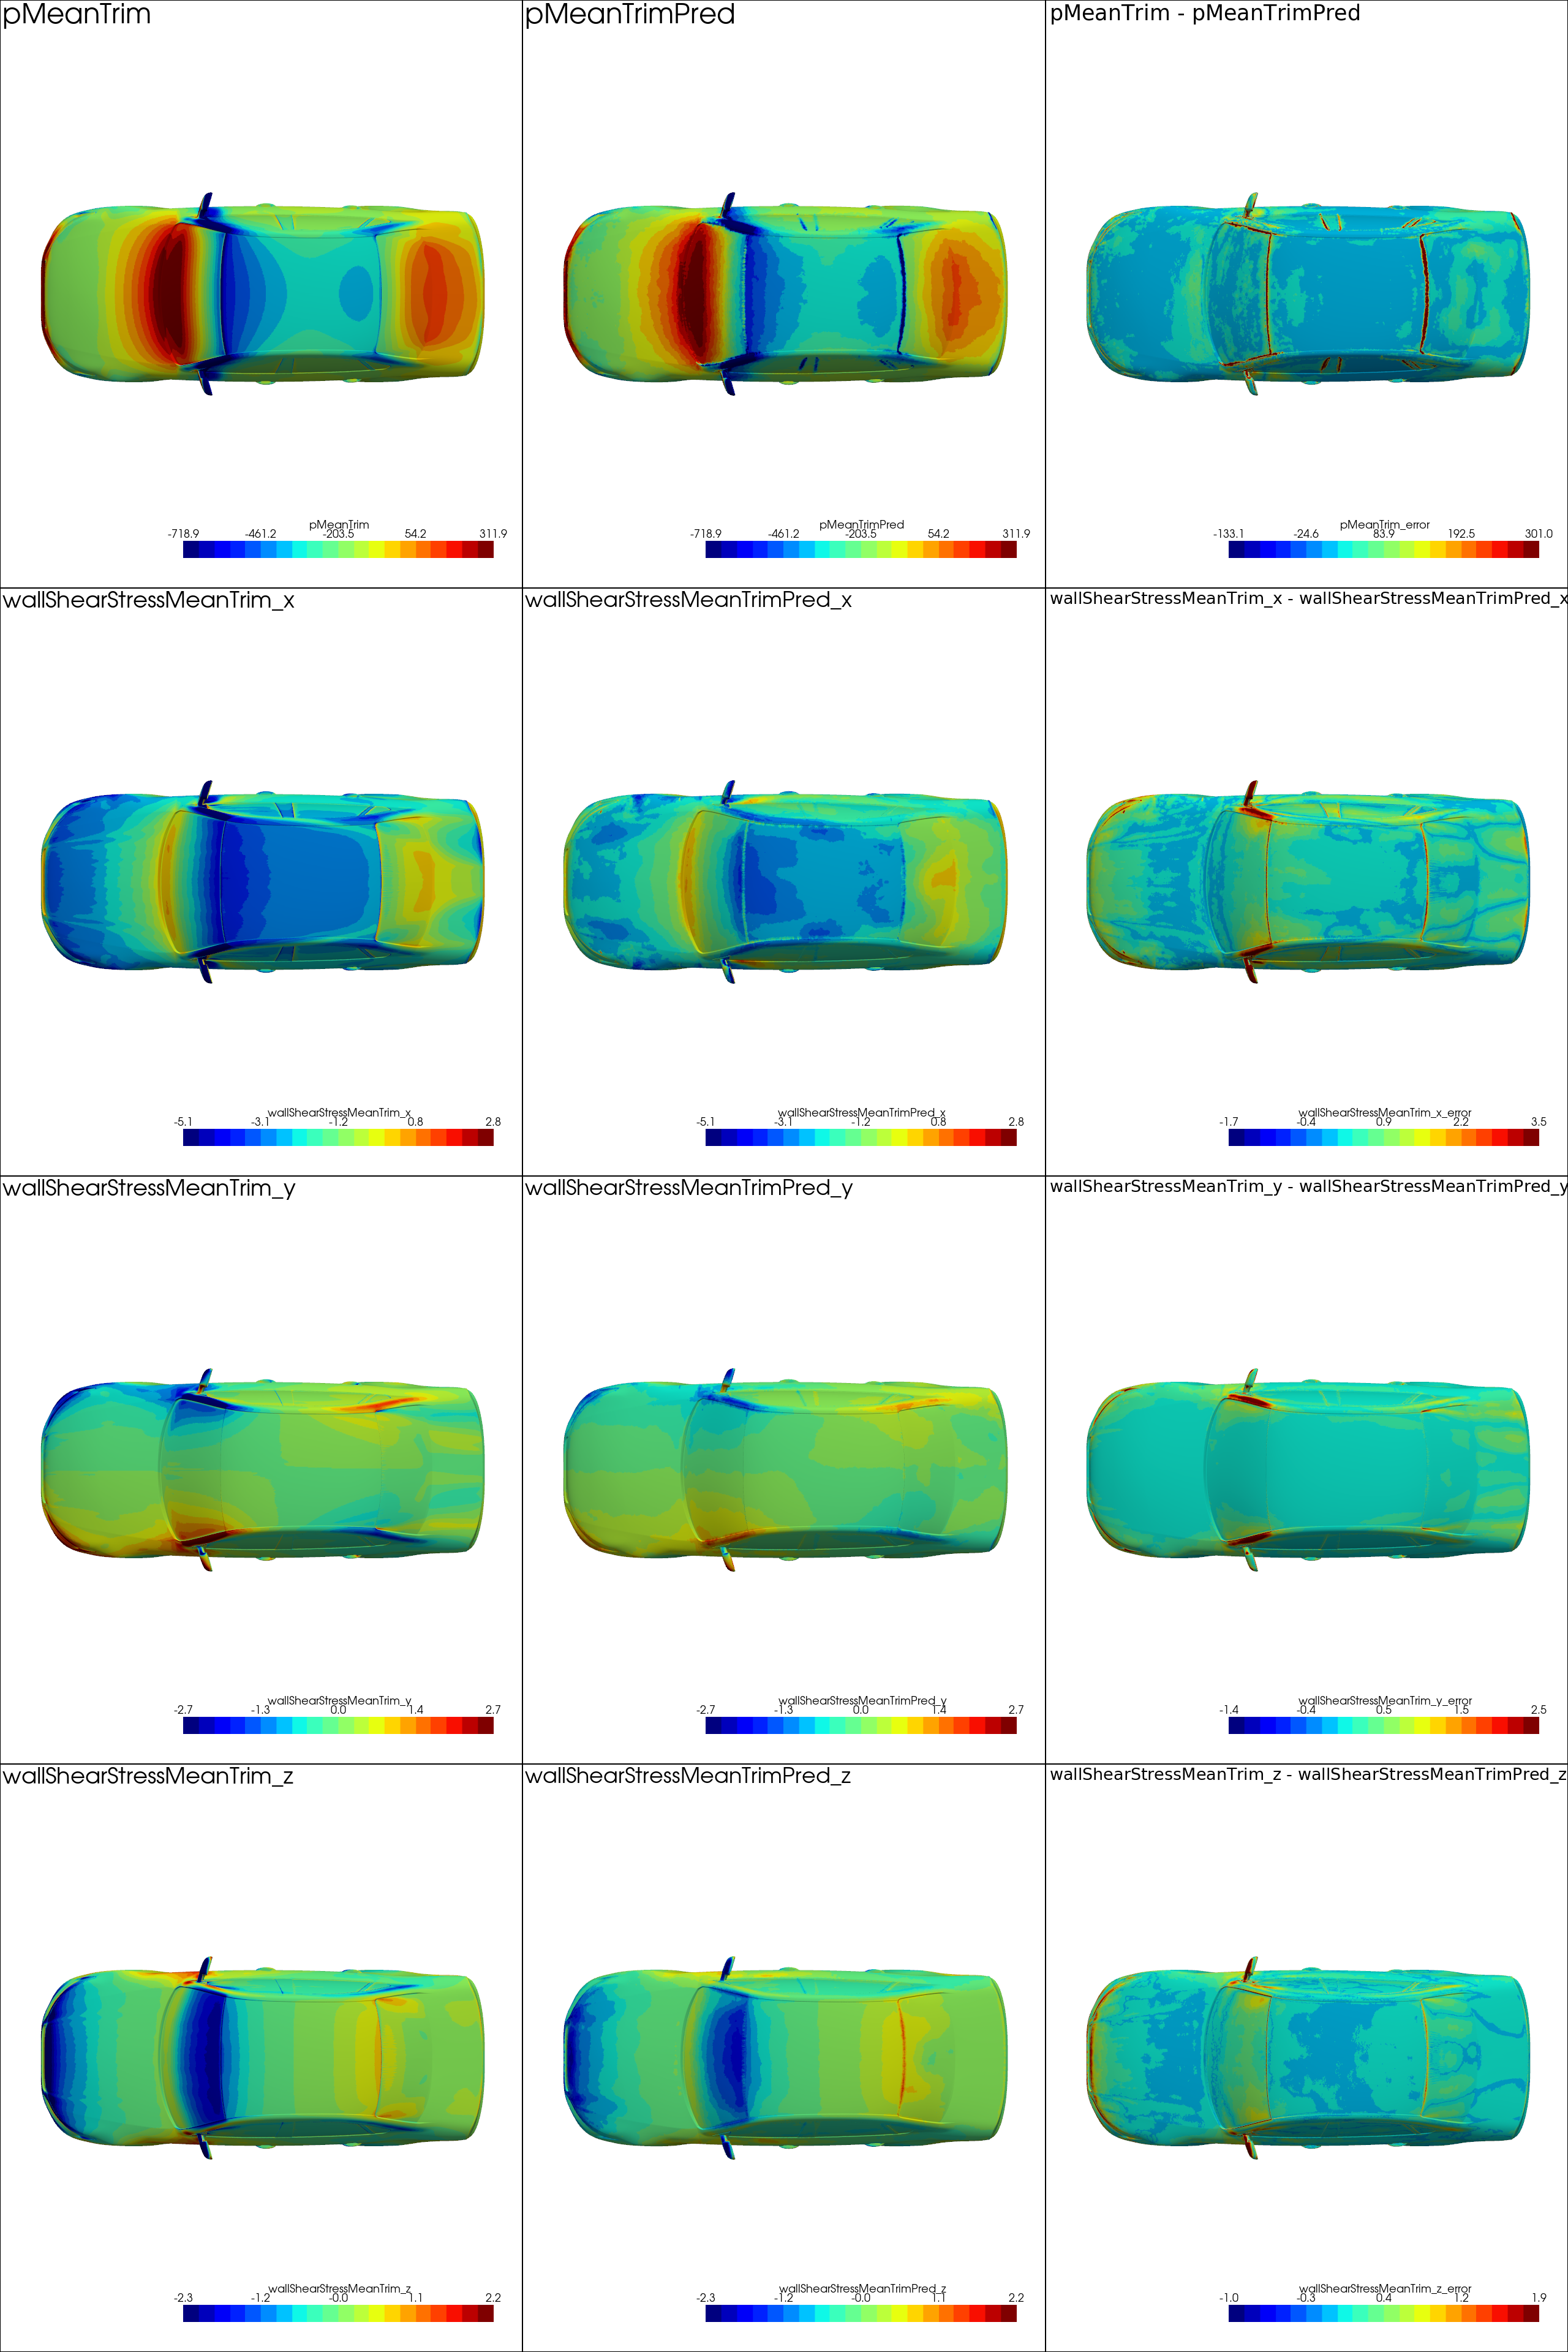

In [ ]:
# now available in physicsnemo-cfd as physicsnemo.cfd.bench.visualization.utils.plot_field_comparisons
from physicsnemo_cfd.utils import plot_field_comparisons

pv.start_xvfb()  # might require apt-get install xvfb

plotter = plot_field_comparisons(
    mesh,
    true_fields=["pMeanTrim", "wallShearStressMeanTrim"],
    pred_fields=["pMeanTrimPred", "wallShearStressMeanTrimPred"],
    view="xy",
    plot_vector_components=True,
    cmap="jet",
    lut=20,
    std=False
)

filename = "outputs/plots/sample_202_surface_comparison.png"

plotter.screenshot(filename)

Image(filename=filename)

The visualization reveals that the AI prediction captures the larger structures in the flow field for most variables, except the x-component of wall shear stress, where it struggles with the flow structures on the hood and roof. For other variables, larger errors are observed near the mirrors and sharp edges.

Such visualizations do not show how predictions look across the entire validation dataset. For that, one can project errors from different samples onto fixed planes and build aggregate visualizations. The [`generate_surface_benchmarks.py`](https://github.com/NVIDIA/physicsnemo-cfd/blob/main/workflows/bench_example/generate_surface_benchmarks.py) script provides this capability.


Overall, errors are typically higher near the intersections of the front windshield with the roof and the rear windshield with the roof. Errors are also higher near the front of the vehicle.

Such analysis is especially useful when geometric differences between samples are modest (e.g., DrivAerML), where such projections enable meaningful aggregate visualizations.

We can also create line plots for more detailed visualization and comparison. Here, we plot the pressure along the centerline of the car.

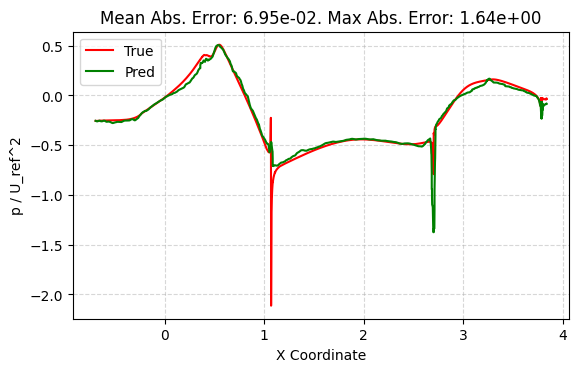

In [ ]:
# now available in physicsnemo-cfd as physicsnemo.cfd.bench.visualization.utils.plot_line
from physicsnemo_cfd.utils import plot_line

# create a slice along xz plane
centerline = mesh.slice(origin=(0, 0, 0), normal=(0, 1, 0))
centerline = centerline.clip(
    origin=(0, 0, 0.4), normal=(0, 0, 1), invert=False
)  # Select only the top half
centerline = centerline.cell_data_to_point_data(pass_cell_data=True)

fig = plot_line(
    centerline,
    plot_coord="x",
    field_true="pMeanTrim",
    field_pred="pMeanTrimPred",
    normalize_factor=(38.89**2) / 2,
    flip=False,
    xlabel="X Coordinate",
    ylabel="p / U_ref^2",
    true_line_kwargs={"color": "red", "label": "True"},
    pred_line_kwargs={"color": "green", "label": "Pred"},
    figsize=(6, 4),
)

Aside from the sharp peaks, the centerline pressure matches the ground truth well.

Now moving onto the volume: 
Much of volumetric data analysis relies on visualizing the flow field for specific features of interest. Let's create a few slices and use again `plot_field_comparisons` to generate visuals.

In [ ]:
# Create a slice that runs along the centerline
y_slice = volume_mesh.slice(normal="y", origin=(0, 0, 0))
y_slice = y_slice.clip_box(bounds, invert=False)

# Create a slice to visualize the wake of the car
x_4_slice = volume_mesh.slice(normal="x", origin=(4, 0, 0))
x_4_slice = x_4_slice.clip_box(bounds, invert=False)

# Create a slice normal to z axis to visualize the wheel wakes
z_neg_0_2376_slice = volume_mesh.slice(normal="z", origin=(0, 0, -0.2376))
z_neg_0_2376_slice = z_neg_0_2376_slice.clip_box(bounds, invert=False)

2025-09-01 18:23:08.437 ( 568.485s) [    7FFFF7C76300]      vtkPolyhedron.cxx:1822  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2025-09-01 18:23:08.639 ( 568.687s) [    7FFFF7C76300]      vtkPolyhedron.cxx:1822  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2025-09-01 18:23:17.270 ( 577.318s) [    7FFFF7C76300]      vtkPolyhedron.cxx:1822  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2025-09-01 18:23:17.592 ( 577.640s) [    7FFFF7C76300]      vtkPolyhedron.cxx:1822  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2025-09-01 18:23:31.317 ( 591.364s) [    7FFFF7C76300]      vtkPolyhedron.cxx:1822  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2025-09-01 18:23:37.015 ( 597.063s) [    7FFFF7C76300]      vtkPolyhedron.cxx:18

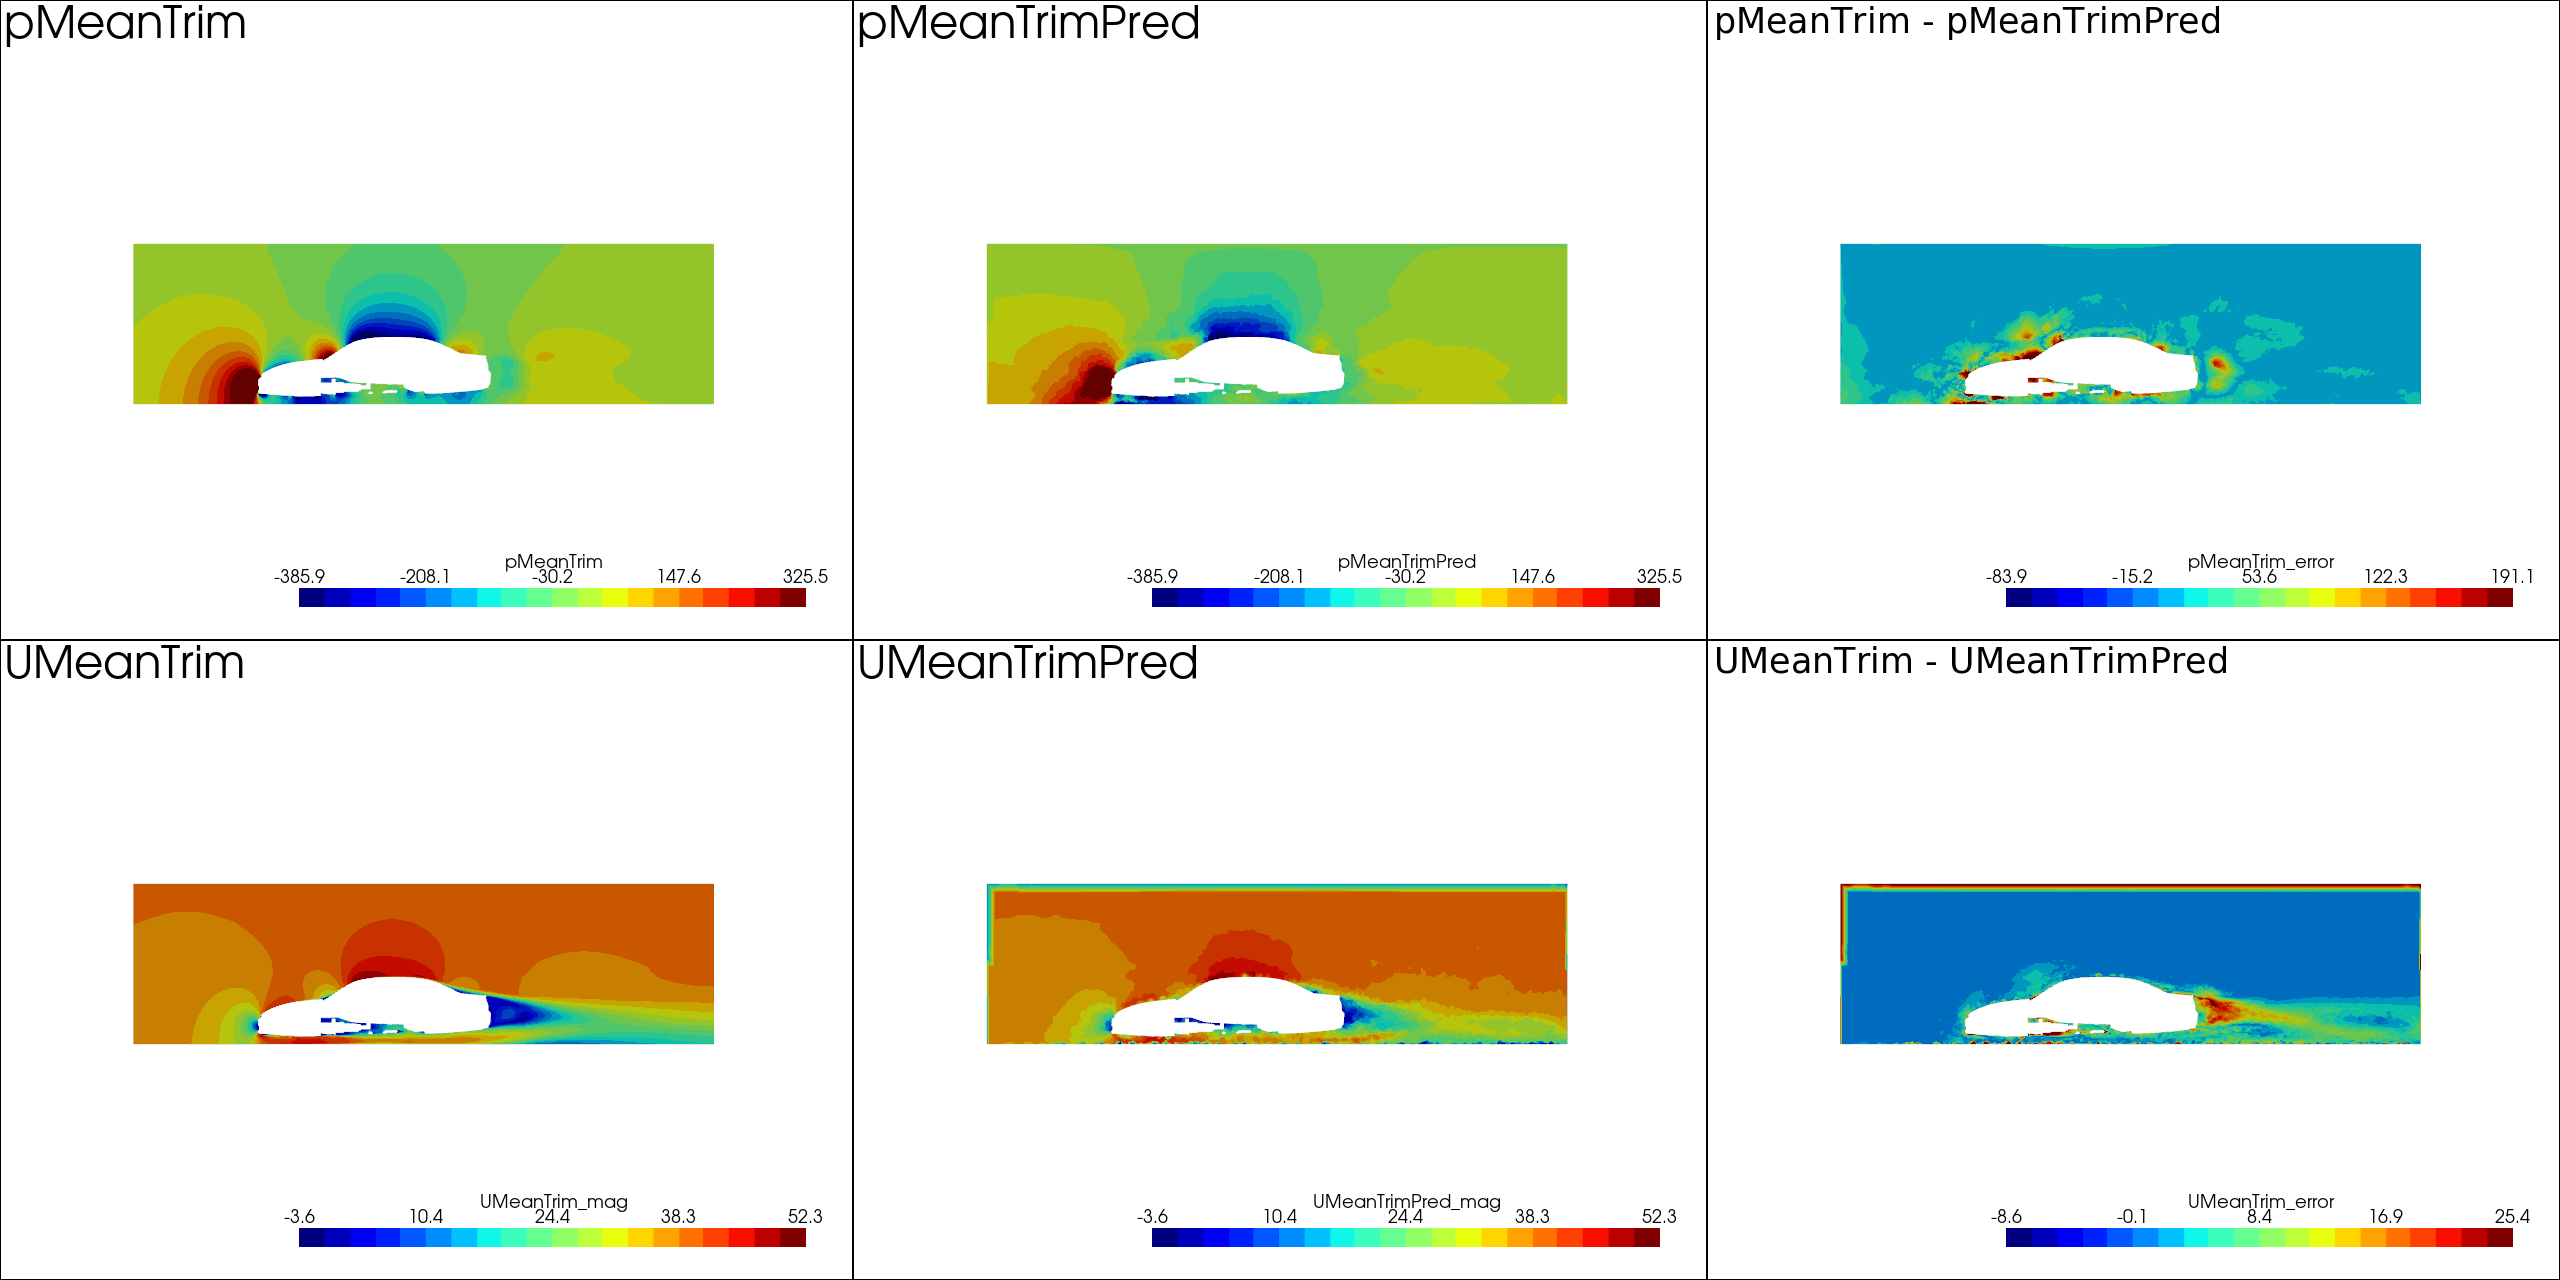

In [ ]:
plotter = plot_field_comparisons(
    y_slice,
    true_fields=["pMeanTrim", "UMeanTrim"],
    pred_fields=["pMeanTrimPred", "UMeanTrimPred"],
    plot_vector_components=False,
    view="xz",
    dtype="point",
    cmap="jet",
    lut=20,
    window_size=[2560, 1280],
)

filename = "outputs/plots/sample_202_volume_y_slice_comparison.png"

plotter.screenshot(filename)

Image(filename=filename)

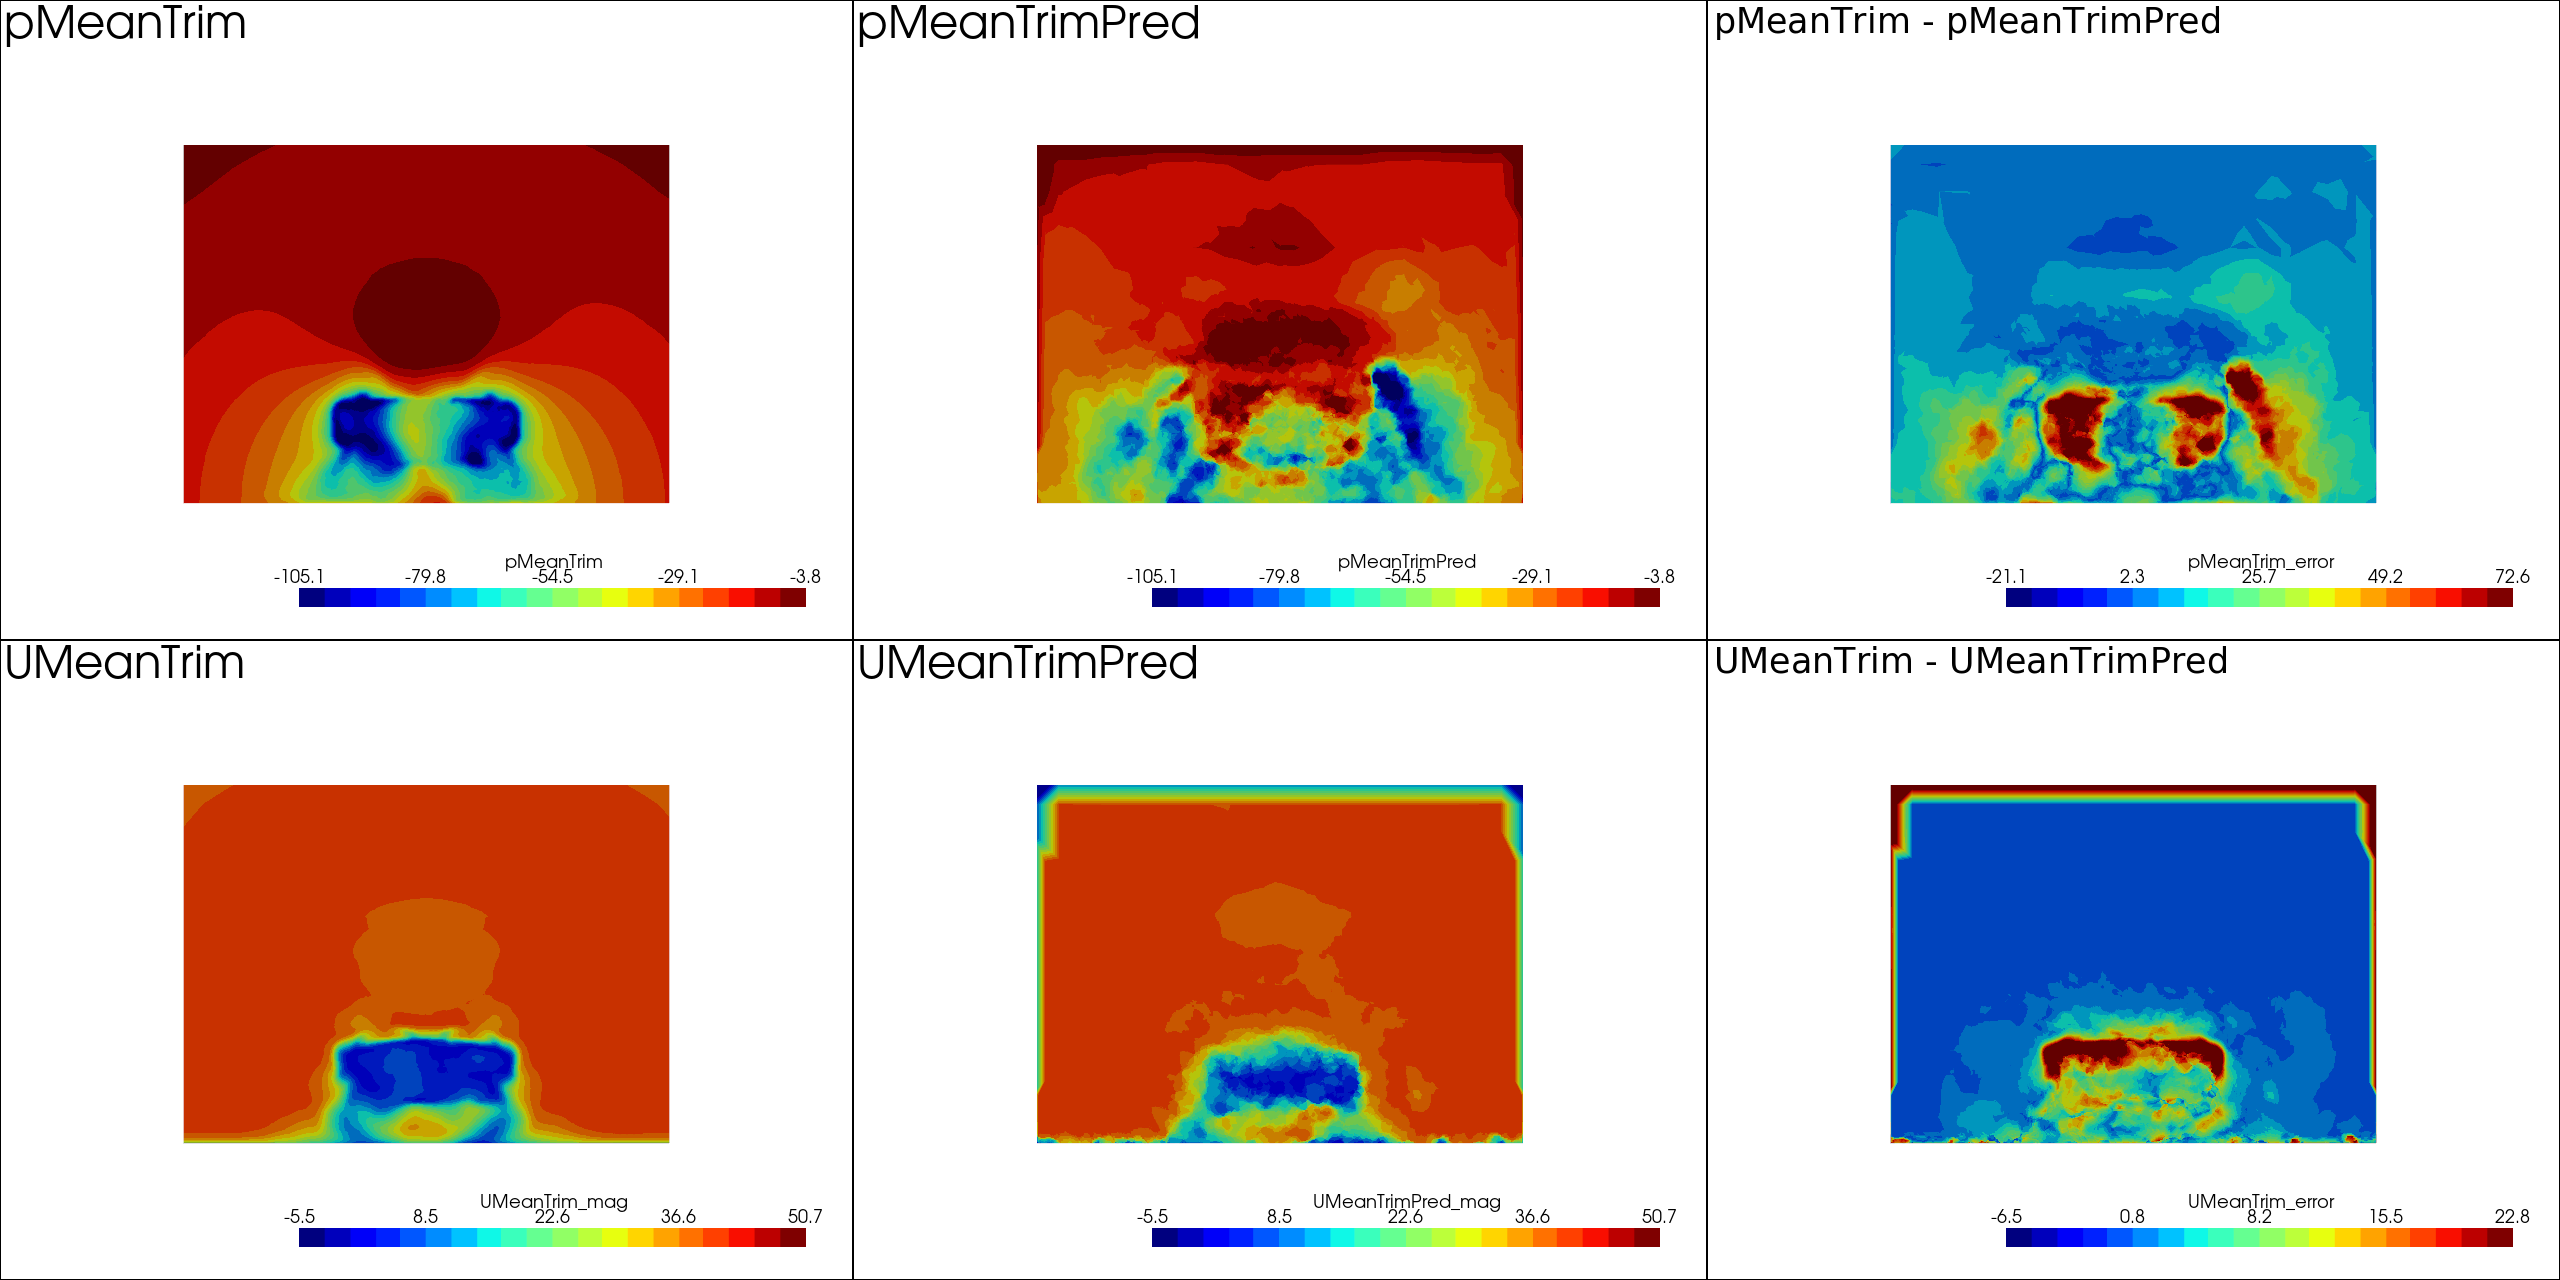

In [ ]:
plotter = plot_field_comparisons(
    x_4_slice,
    true_fields=["pMeanTrim", "UMeanTrim"],
    pred_fields=["pMeanTrimPred", "UMeanTrimPred"],
    plot_vector_components=False,
    view="yz",
    dtype="point",
    cmap="jet",
    lut=20,
    window_size=[2560, 1280],
)

filename = "outputs/plots/sample_202_volume_x_4_slice_comparison.png"

plotter.screenshot(filename)

Image(filename=filename)

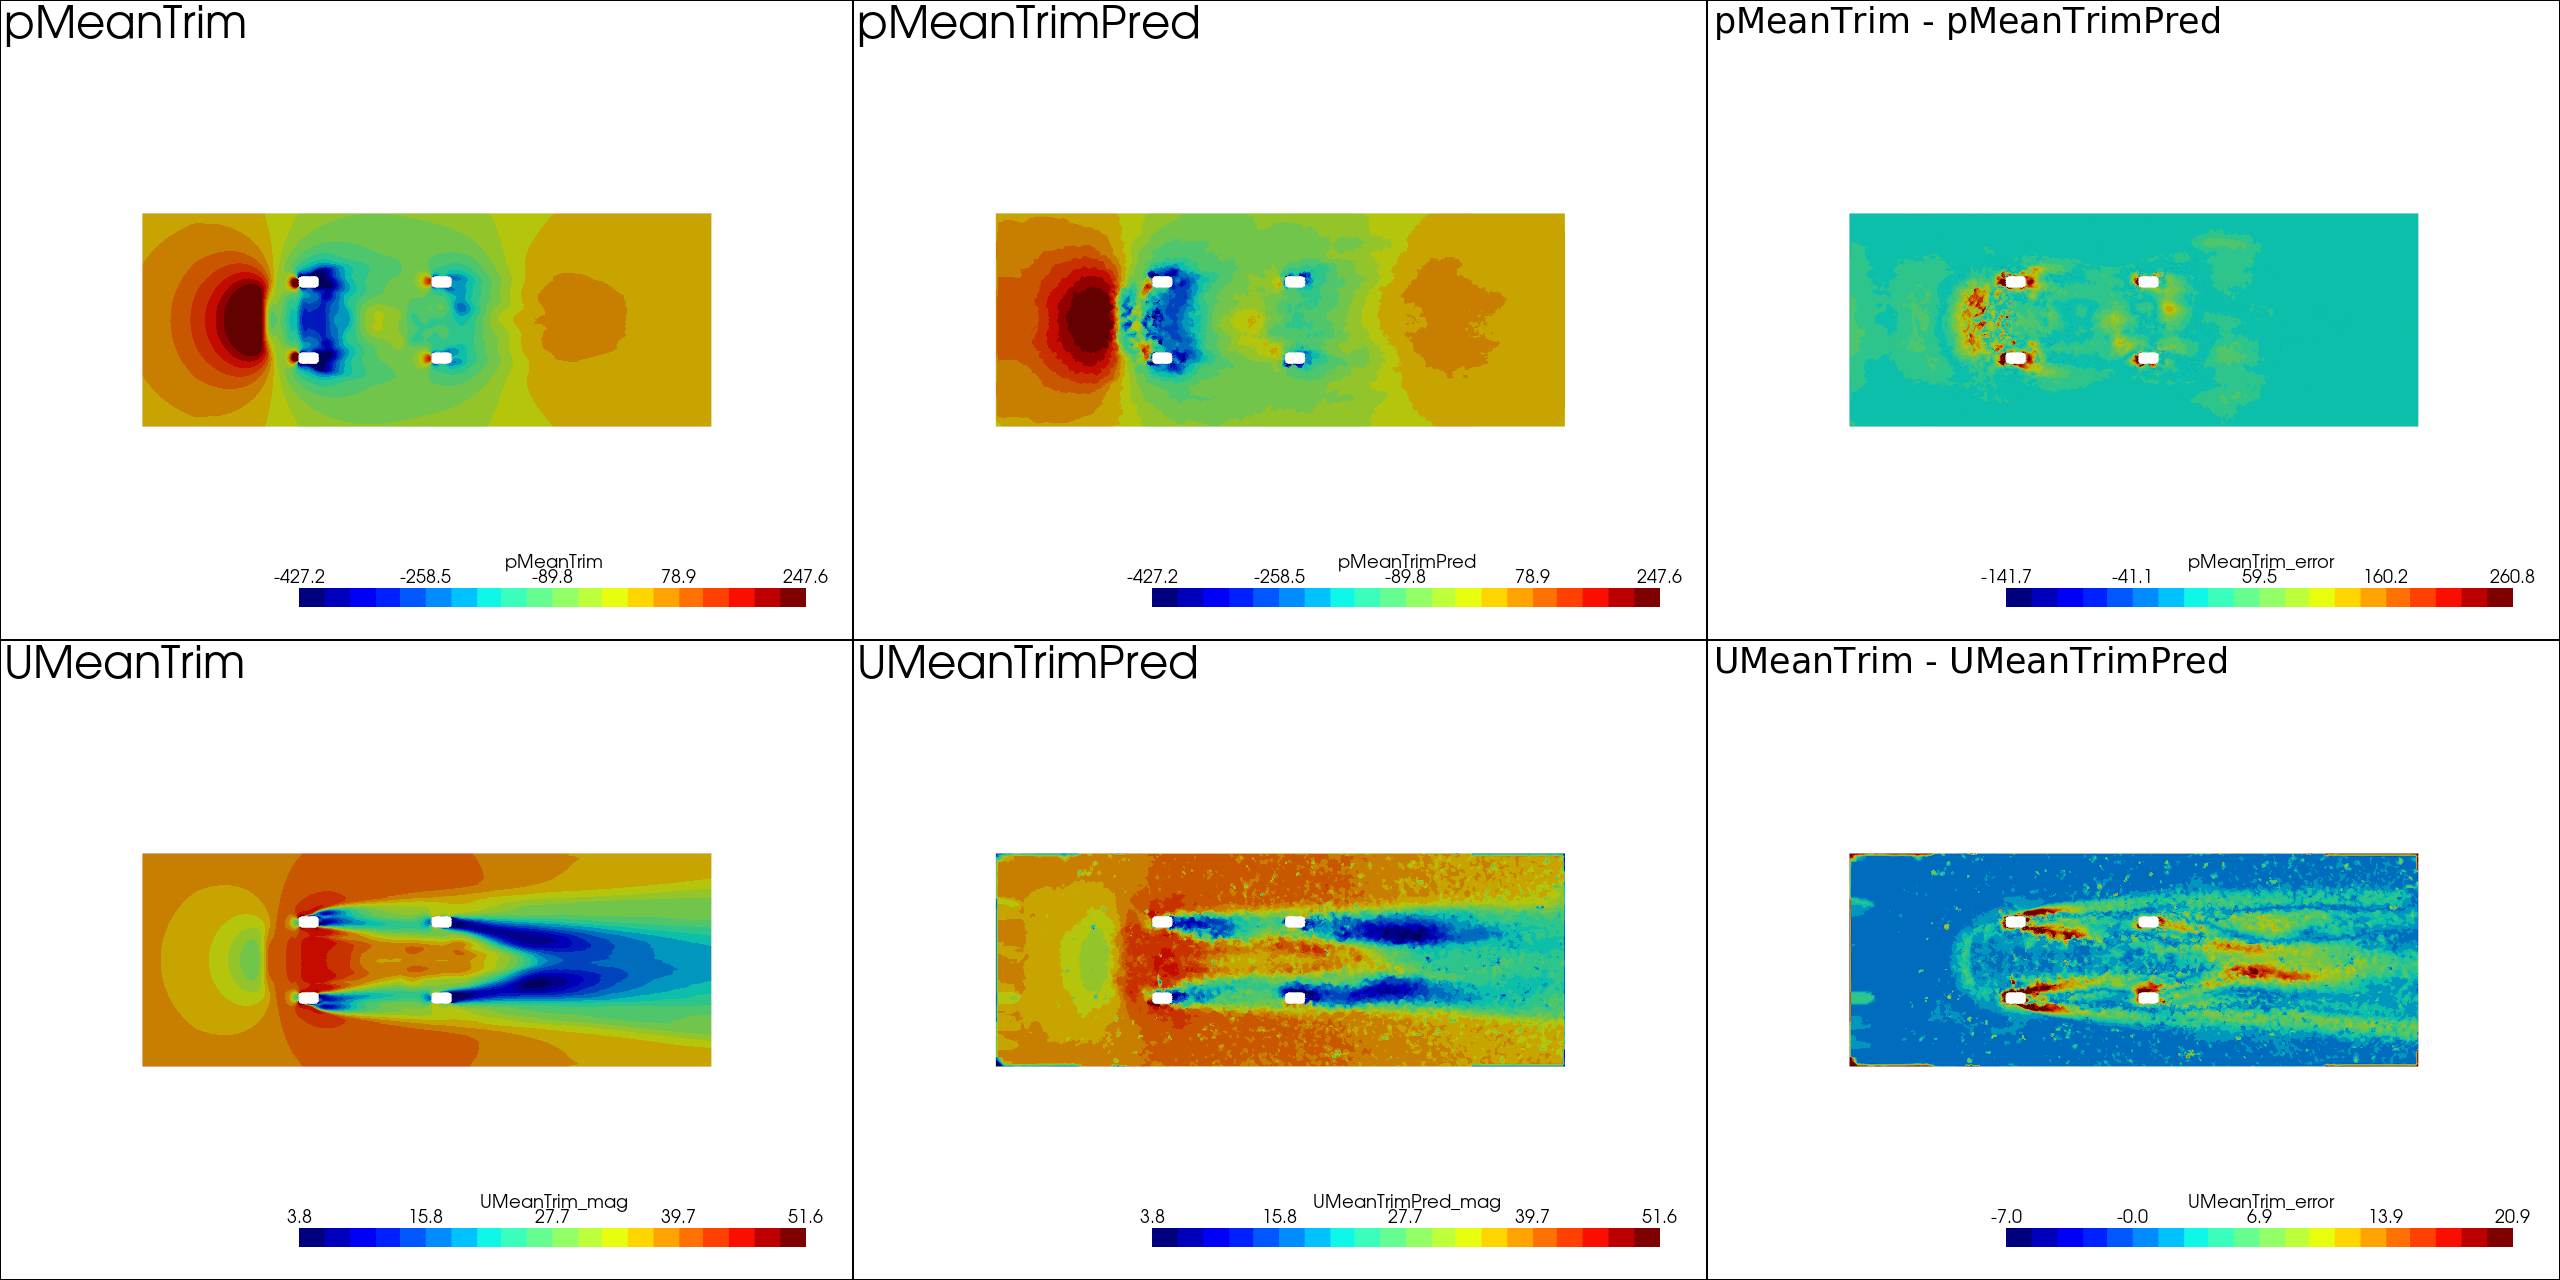

In [ ]:
plotter = plot_field_comparisons(
    z_neg_0_2376_slice,
    true_fields=["pMeanTrim", "UMeanTrim"],
    pred_fields=["pMeanTrimPred", "UMeanTrimPred"],
    plot_vector_components=False,
    view="xy",
    dtype="point",
    cmap="jet",
    lut=20,
    window_size=[2560, 1280],
)

filename = "outputs/plots/sample_202_volume_z_slice_comparison.png"

plotter.screenshot(filename)

Image(filename=filename)

Slice visualizations show that the AI prediction captures the larger structures in the flow field. Predictions are somewhat noisy, some of which can be attributed to interpolating NIM results from ~500k points to ~160M points.

Such visualizations do not reveal how predictions look across the entire validation dataset. For that, one can project errors from different samples onto fixed points and build aggregate visualizations. The [`generate_volume_benchmarks.py`](https://github.com/NVIDIA/physicsnemo-cfd/blob/main/workflows/bench_example/generate_volume_benchmarks.py) script provides this capability.

Below we show the error distribution across the entire DrivAerML validation set (visualized using sample ID 439, the largest STL by geometric size).

![Aggregate Errors](images/resampled_volume_errors.png)

Overall, errors are typically higher in the wake for velocity, closer to the car surface for pressure, and in the farfield for turbulent viscosity.

Such analysis is especially useful when geometric differences between samples are modest (e.g., DrivAerML), where resampling techniques enable meaningful aggregate visualizations.

### L2 Errors

Let's compare the L2 errors for the pressure and the wall shear stress fields on the surface. We will use the `compute_l2_errors` function from the library. 

In [ ]:
# now available in physicsnemo-cfd as physicsnemo.cfd.bench.metrics.l2_errors.compute_l2_errors
from physicsnemo_cfd.l2_errors import compute_l2_errors

l2_errors = compute_l2_errors(
    mesh,
    true_fields=["pMeanTrim", "wallShearStressMeanTrim"],
    pred_fields=["pMeanTrimPred", "wallShearStressMeanTrimPred"],
    dtype="cell",
)
l2_errors

{'pMeanTrim_l2_error': 0.4178350048727104,
 'wallShearStressMeanTrim_x_l2_error': 0.6857106355173721,
 'wallShearStressMeanTrim_y_l2_error': 0.8327694357926416,
 'wallShearStressMeanTrim_z_l2_error': 0.7441545055338803}

This provides a numerical comparison of the model's overall performance.

Meshes are typically refined with smaller triangles in areas of high geometric detail. We can compute area-weighted L2 errors to see how the error relates to cell size using `compute_area_weighted_l2_errors`. Note: this metric only works for `cell` dtype.

In [ ]:
from physicsnemo_cfd.l2_errors import compute_area_weighted_l2_errors

area_weighted_l2_errors = compute_area_weighted_l2_errors(
    mesh,
    true_fields=["pMeanTrim", "wallShearStressMeanTrim"],
    pred_fields=["pMeanTrimPred", "wallShearStressMeanTrimPred"],
    dtype="cell",
)
area_weighted_l2_errors

{'pMeanTrim_area_wt_l2_error': 0.3360464543965369,
 'wallShearStressMeanTrim_x_area_wt_l2_error': 0.44108572793763046,
 'wallShearStressMeanTrim_y_area_wt_l2_error': 0.7060483480817462,
 'wallShearStressMeanTrim_z_area_wt_l2_error': 0.6516189947966922}

Now the same for the volume fields. Let's compare the L2 errors for the pressure, velocity, and turbulent viscosity fields using the library function `compute_l2_errors`. We pass the `bounds` argument to restrict the computation to the region where model results are available.

In [ ]:
l2_errors = compute_l2_errors(
    volume_mesh,
    true_fields=["pMeanTrim", "UMeanTrim"],
    pred_fields=["pMeanTrimPred", "UMeanTrimPred"],
    bounds=[-3.5, 8.5, -2.25, 2.25, -0.32, 3.00],
    dtype="point",
)
l2_errors

{'pMeanTrim_l2_error': 0.6506529291719394,
 'UMeanTrim_x_l2_error': 0.685013182810399,
 'UMeanTrim_y_l2_error': 0.9891877644925599,
 'UMeanTrim_z_l2_error': 0.8375282099653328}

L2 errors provide an aggregate sense of model performance, but they do not reveal the distribution of errors. Below, we compute the distribution of absolute errors as a function of distance from the STL.

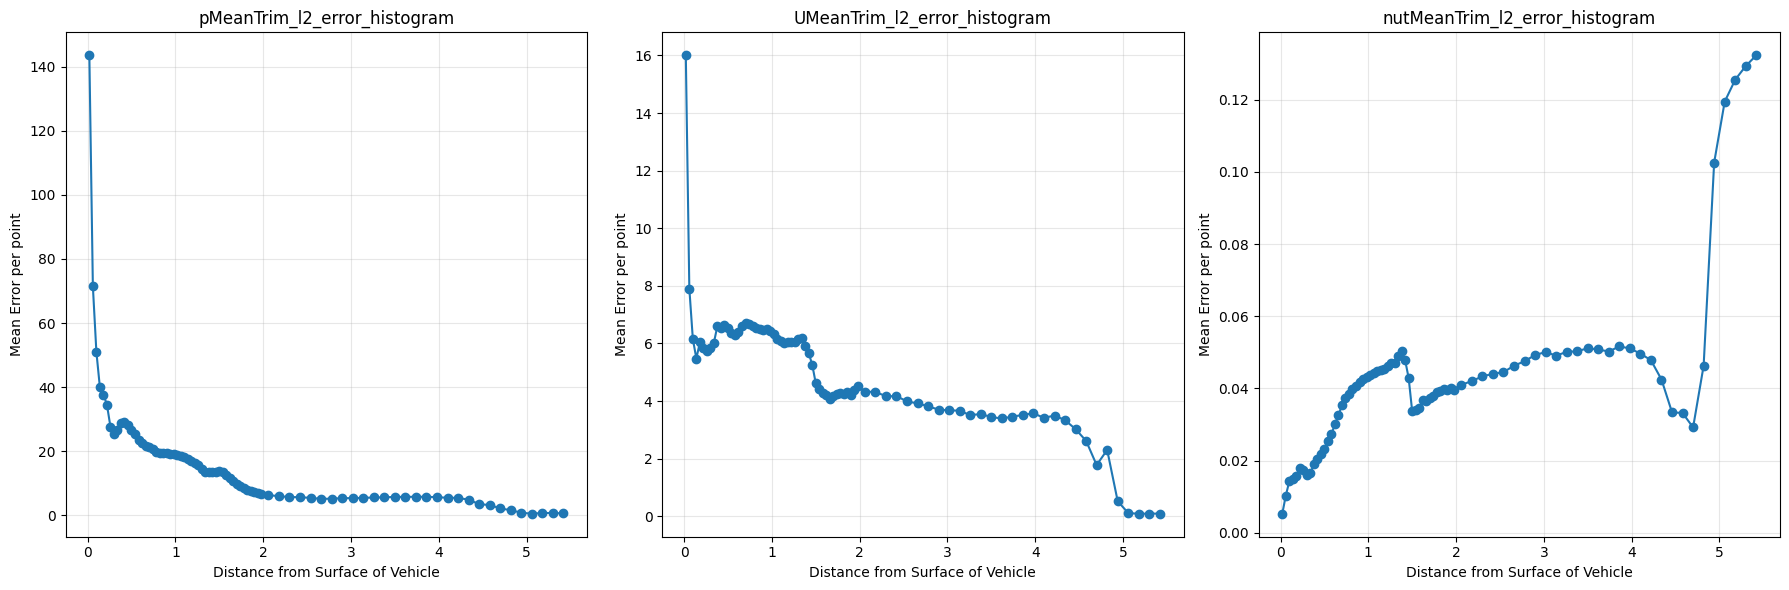

In [ ]:
from physicsnemo_cfd.l2_errors import compute_error_vs_sdf
import matplotlib.pyplot as plt

# determine query points for sdf
bin_edges = np.linspace(0, 2, 50, endpoint=False)
bin_edges = np.concatenate([bin_edges, np.linspace(2, 8, 51)])

stl_mesh = pv.read("data/drivaer_202_single_solid.stl")

output_dict = compute_error_vs_sdf(
    volume_mesh,
    ["pMeanTrim", "UMeanTrim", "nutMeanTrim"],
    ["pMeanTrimPred", "UMeanTrimPred", "nutMeanTrimPred"],
    stl_mesh,
    bin_edges,
    bounds=[-3.5, 8.5, -2.25, 2.25, -0.32, 3.00],
    dtype="point"
)
# print(output_dict)
keys_to_plot = [key for key in output_dict.keys() if "histogram" in key]
fig, axs = plt.subplots(1, len(keys_to_plot), figsize=(18,6))
for i, key in enumerate(keys_to_plot):
    ax = axs[i]
    bin_centers = output_dict[key]["bin_edges"]
    bin_centers = [(a + b) / 2 for a, b in zip(bin_centers, bin_centers[1:])]
    errors = output_dict[key]["mean_errors"]
    ax.plot(bin_centers, errors, marker='o')
    ax.set_title(key)
    ax.set_xlabel('Distance from Surface of Vehicle')
    ax.set_ylabel('Mean Error per point')
    ax.grid(True, alpha=0.3)
plt.tight_layout()

We observe that for pressure and velocity, error is higher near the STL surface, while for turbulent viscosity the trend is reversed. This can inform model architecture or loss weighting choices. Below, we show this distribution computed across the entire DrivAerML validation dataset.

![Aggregate Error as a function of SDF](images/error_vs_sdf.png)


### Computing drag metrics

Drag force is an important consideration for the efficiency and performance of the vehicle. We can use the `compute_drag_and_lift` function to compute the drag and lift coefficient / forces

In [ ]:
# now available in physicsnemo-cfd as physicsnemo.cfd.bench.metrics.aero_forces.compute_drag_and_lift
from physicsnemo_cfd.aero_forces import compute_drag_and_lift

forces_true = compute_drag_and_lift(
    mesh,
    pressure_field="pMeanTrim",
    wss_field="wallShearStressMeanTrim",
    coeff=1.0,  # Set it to 1.0 to get raw forces. can be replaced 2 / (rho * u * u * ref_area) for coefficients
    drag_direction=[1, 0, 0],
    lift_direction=[0, 0, 1],
    dtype="cell",
)  # retruns F_drag, F_drag_pressure, F_drag_skin_friction, F_lift, F_lift_pressure, F_lift_skin_friction

forces_pred = compute_drag_and_lift(
    mesh,
    pressure_field="pMeanTrimPred",
    wss_field="wallShearStressMeanTrimPred",
    coeff=1.0,  # Set it to 1.0 to get raw forces. can be replaced 2 / (rho * u * u * ref_area) for coefficients
    drag_direction=[1, 0, 0],
    lift_direction=[0, 0, 1],
    dtype="cell",
)  # retruns F_drag, F_drag_pressure, F_drag_skin_friction, F_lift, F_lift_pressure, F_lift_skin_friction

labels = ["Drag Force (D)", "D_p", "D_f", "Lift Force (L)", "L_p", "L_f"]
for label, f_true, f_pred in zip(labels, forces_true, forces_pred):
    print(
        f"{label}: True: {f_true}, Pred: {f_pred}, Error (%): {abs(f_true - f_pred) * 100 / f_true}"
    )

Drag Force (D): True: 482.3444254302631, Pred: 441.489453802436, Error (%): 8.470082678240436
D_p: True: 435.0610781379878, Pred: 403.7159761928828, Error (%): 7.204758945401066
D_f: True: 47.28334729227524, Pred: 37.77347760955322, Error (%): 20.112513659276537
Lift Force (L): True: 37.28053920122983, Pred: 198.49689355770064, Error (%): 432.4410478246316
L_p: True: 34.24916887927558, Pred: 194.7779421050518, Error (%): 468.7085219253696
L_f: True: 3.03137032195425, Pred: 3.718951452648837, Error (%): 22.682188504482053


When computing drag and lift across many cases, you can use visualization utilities such as `physicsnemo.cfd.bench.visualization.utils.plot_design_scatter` and `physicsnemo.cfd.bench.visualization.utils.plot_design_trend` to compute metrics (e.g., R2 scores), compare design trends, and measure the ability of models to capture directional changes. The workflow scripts [`generate_surface_benchmarks.py`](https://github.com/NVIDIA/physicsnemo-cfd/blob/main/workflows/bench_example/generate_surface_benchmarks.py) and [`generate_volume_benchmarks.py`](https://github.com/NVIDIA/physicsnemo-cfd/blob/main/workflows/bench_example/generate_volume_benchmarks.py) use these functions to create plots like the examples below, as well as run these metrics across multiple geometries or cases:

![Sample R2 score plot](images/design_scatter_plot.png)

![Sample design trend plot](images/design_trend_plot.png)


## Confidence Scores and Reliability

Error quantification is essential for building trust in AI surrogate models. It essentially provides guard rails for AI which is vital information for engineers informing them on how much to rely or not rely on AI for the specific task. AI powered CAE applications need to provide appropriate reliability or confidence metrics when using AI surrogates, especially when you are evaluating pretrained models.

There are a few different ways to estimate the confidence of AI surrogate model prediction using DoMINO NIM has been added. This can be extended to any trained model:

- Sensitivity to Input (STL) Resolution: By creating realizations of the input STL at various mesh densities and distributions, we can study the uncertainty of the surrogate prediction to the STL's resolution
 - Sensitivity to Model bias: By using an ensemble of checkpoints trained on the same data, we can study the uncertainty of the surrogate prediction
- Sensitivity to ground truth data distribution: By quantifying the similarity of the given input geometry, we can estimate the confidence of the surrogate prediction in terms of in-distribution or out-of-distribution

### Analyze the Model's Sensitivity to Input (STL) Resolution

The DoMINO model used in this study takes in the STL file and predicts the solution on desired points. We can study how sensitive the model is to the STL's resolution by creating realizations of the same STL at various mesh densities and distributions.

In [ ]:
mesh = trimesh.load_mesh(stl_file_path)

# Clean up files if called multiple times (rm remeshed_variant_*)
for file in glob.glob("data/remeshed_variant_*.stl"):
    os.remove(file)
    
# Create a few remeshed variants
for variant in range(8):
    remeshed_mesh = mesh.copy()
    
    if variant == 0:
        target_faces = int(len(remeshed_mesh.faces) * 0.5)
        remeshed_mesh = remeshed_mesh.simplify_quadric_decimation(face_count=target_faces)
        
    elif variant == 1:
        target_faces = int(len(remeshed_mesh.faces) * 0.25)
        remeshed_mesh = remeshed_mesh.simplify_quadric_decimation(face_count=target_faces)
        
    elif variant == 2:
        remeshed_mesh = remeshed_mesh.subdivide()
              
    elif variant == 3:
        remeshed_mesh.update_faces(remeshed_mesh.nondegenerate_faces())
        remeshed_mesh.update_faces(remeshed_mesh.unique_faces())
        remeshed_mesh.remove_infinite_values()
        remeshed_mesh.remove_unreferenced_vertices()
        
    elif variant == 4:
        remeshed_mesh.fix_normals()
        
    elif variant == 5:
        target_faces = int(len(remeshed_mesh.faces) * 0.7)
        remeshed_mesh = remeshed_mesh.simplify_quadric_decimation(face_count=target_faces)
        remeshed_mesh = remeshed_mesh.subdivide()
        
    elif variant == 6:
        remeshed_mesh = remeshed_mesh.subdivide()
        target_faces = int(len(remeshed_mesh.faces) * 0.6)
        remeshed_mesh = remeshed_mesh.simplify_quadric_decimation(face_count=target_faces)
        
    elif variant == 7:
        remeshed_mesh.update_faces(remeshed_mesh.nondegenerate_faces())
        remeshed_mesh.update_faces(remeshed_mesh.unique_faces())
        remeshed_mesh.remove_infinite_values()
        target_faces = int(len(remeshed_mesh.faces) * 0.8)
        remeshed_mesh = remeshed_mesh.simplify_quadric_decimation(face_count=target_faces)
    
    # Ensure watertight mesh for all variants
    remeshed_mesh.fill_holes()
    remeshed_mesh.update_faces(remeshed_mesh.nondegenerate_faces())
    remeshed_mesh.update_faces(remeshed_mesh.unique_faces())
    remeshed_mesh.remove_infinite_values()
    remeshed_mesh.remove_unreferenced_vertices()
    remeshed_mesh.fix_normals()

    print(f"Created remeshed variant {variant}")
    
    # Save the remeshed mesh
    remeshed_mesh.export(f"data/remeshed_variant_{variant}.stl")

stl_files = glob.glob("data/remeshed_variant_*.stl")
mesh = pv.read("data/boundary_202.vtp")

Created remeshed variant 0
Created remeshed variant 1
Created remeshed variant 2
Created remeshed variant 3
Created remeshed variant 4
Created remeshed variant 5
Created remeshed variant 6
Created remeshed variant 7


Now that we have these different variations generated, we can run the NIM on each of them and visualize the standard deviation of the fields on a fixed set of points. These can be any set of points; for this study, we pick them from the "meshed" version of the original STL, i.e., the `.vtp` file. 

In [ ]:
pMeanTrimPred = []
wallShearStressMeanTrimPred = []

# Define the URL for the inference API
url = "http://localhost:8000/v1/infer"

# Define the parameters for the inference request
# reduce stencil size for faster inference
data = {
    "stream_velocity": "38.89",
    "stencil_size": "7",
    "point_cloud_size": "500000",
}

for i, stl_file in enumerate(stl_files):
    print(f"Processing variant {i}")

    # Open the STL file and send it to the NIM
    with open(stl_file, "rb") as file:
        files = {"design_stl": (stl_file, file)}
        r = httpx.post(url, files=files, data=data, timeout=120.0)

    # Load the response content into a NumPy array
    with np.load(io.BytesIO(r.content)) as output_data:
        output_dict = {key: output_data[key] for key in output_data.keys()}  

    # Interpolate the results of the NIM onto the mesh points so 
    # we can stack arrays (requires identical shape)
    mesh_cell_centers = mesh.cell_centers()
    nbrs_surface = _create_nbrs_surface(
        output_dict["surface_coordinates"][0, :], device="gpu"
    )
    fields = np.concatenate(
        [output_dict["pressure_surface"][0, :], output_dict["wall_shear_stress"][0, :]],
        axis=1,
    )
    fields_interp = _interpolate(
        nbrs_surface, mesh_cell_centers.points, fields, device="gpu", batch_size=10_000_000
    )
    pMeanTrimPred.append(fields_interp[:, 0])
    wallShearStressMeanTrimPred.append(fields_interp[:, 1:4])

Processing variant 0
Processing variant 1
Processing variant 2
Processing variant 3
Processing variant 4
Processing variant 5
Processing variant 6
Processing variant 7


In [ ]:
pMeanTrimPred_mean = np.mean(np.stack(pMeanTrimPred, axis=0), axis=0)
pMeanTrimPred_std = np.std(np.stack(pMeanTrimPred, axis=0), axis=0)
wallShearStressMeanTrimPred_mean = np.mean(np.stack(wallShearStressMeanTrimPred, axis=0), axis=0)
wallShearStressMeanTrimPred_std = np.std(np.stack(wallShearStressMeanTrimPred, axis=0), axis=0)

mesh.cell_data[f"pMeanTrimPred_mean"] = pMeanTrimPred_mean
mesh.cell_data[f"pMeanTrimPred_std"] = pMeanTrimPred_std
mesh.cell_data[f"wallShearStressMeanTrimPred_mean"] = wallShearStressMeanTrimPred_mean
mesh.cell_data[f"wallShearStressMeanTrimPred_std"] = wallShearStressMeanTrimPred_std

/workspace/exercises/physicsnemo_cfd/utils.py:592: RuntimeWarning: divide by zero encountered in log10
  if np.log10(np.abs(vmin)) < -1 or np.log10(np.abs(vmax)) < -1:
/workspace/exercises/physicsnemo_cfd/utils.py:665: RuntimeWarning: divide by zero encountered in log10
  if np.log10(np.abs(vmin)) < -1 or np.log10(np.abs(vmax)) < -1:


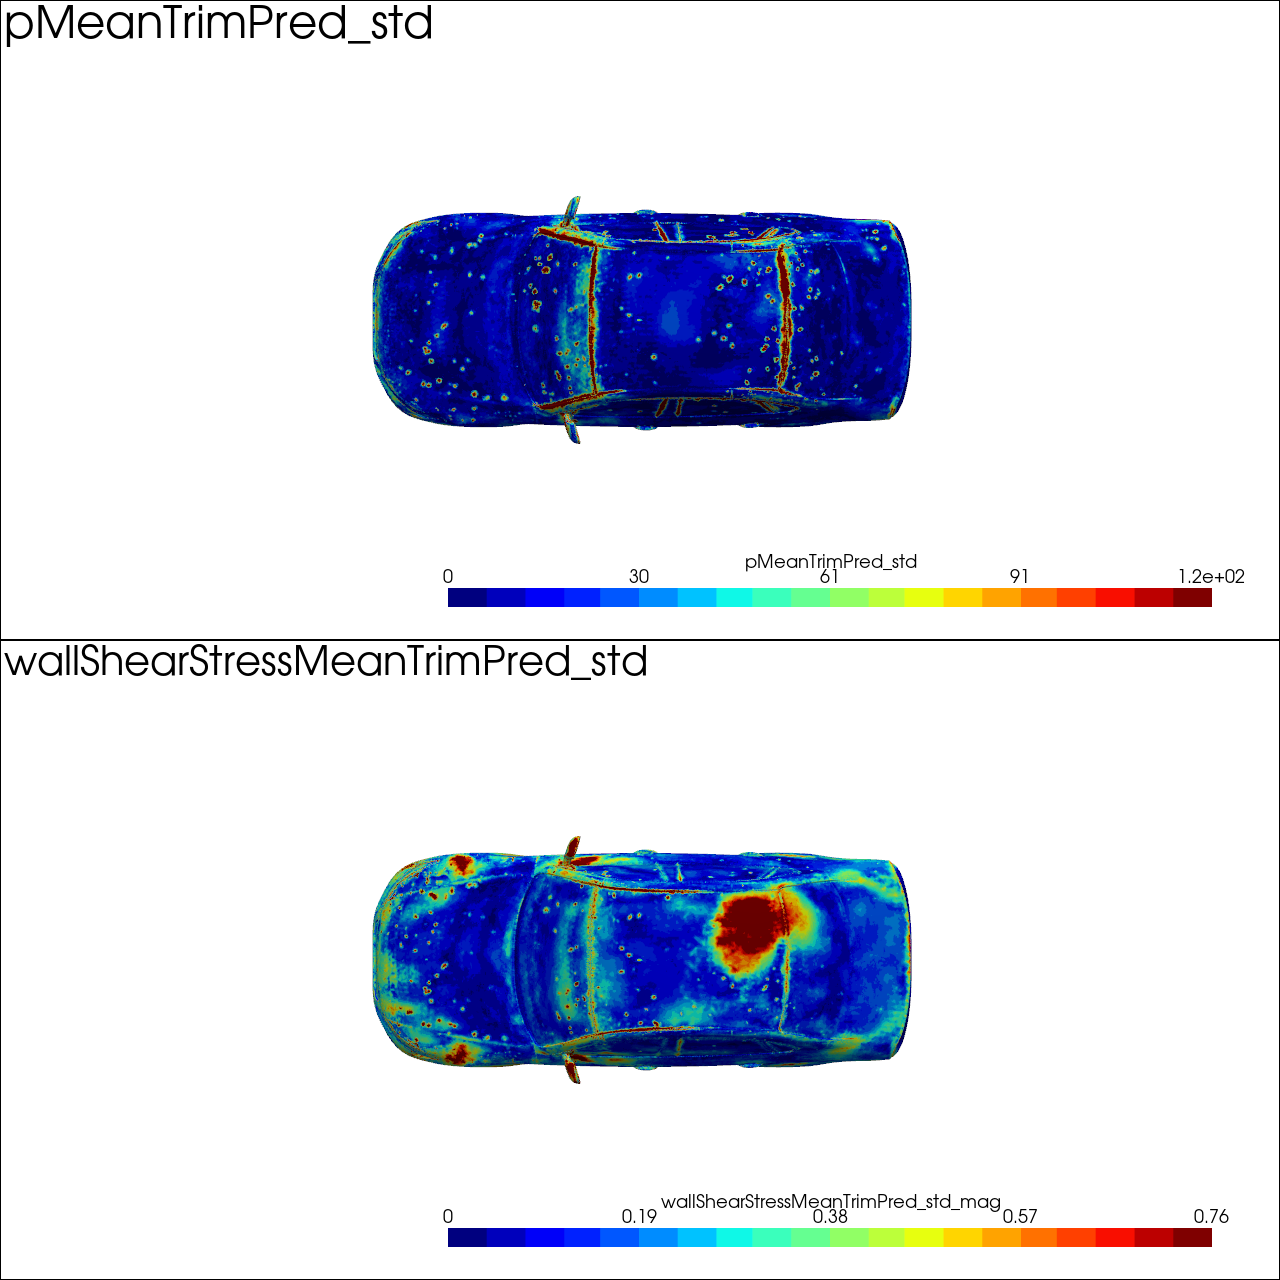

In [ ]:
from physicsnemo_cfd.utils import plot_std_fields

fields_to_plot = ["pMeanTrimPred_std", "wallShearStressMeanTrimPred_std"]
plotter = plot_std_fields(mesh, 
    fields_to_plot,
    plot_vector_components=False,
    view="xy",
    dtype="cell",
    cmap="jet",
    lut=20,
    window_size=[1280, 1280],
)

filename = "outputs/plots/variations_with_mesh_xy.png"

plotter.screenshot(filename)

Image(filename=filename)

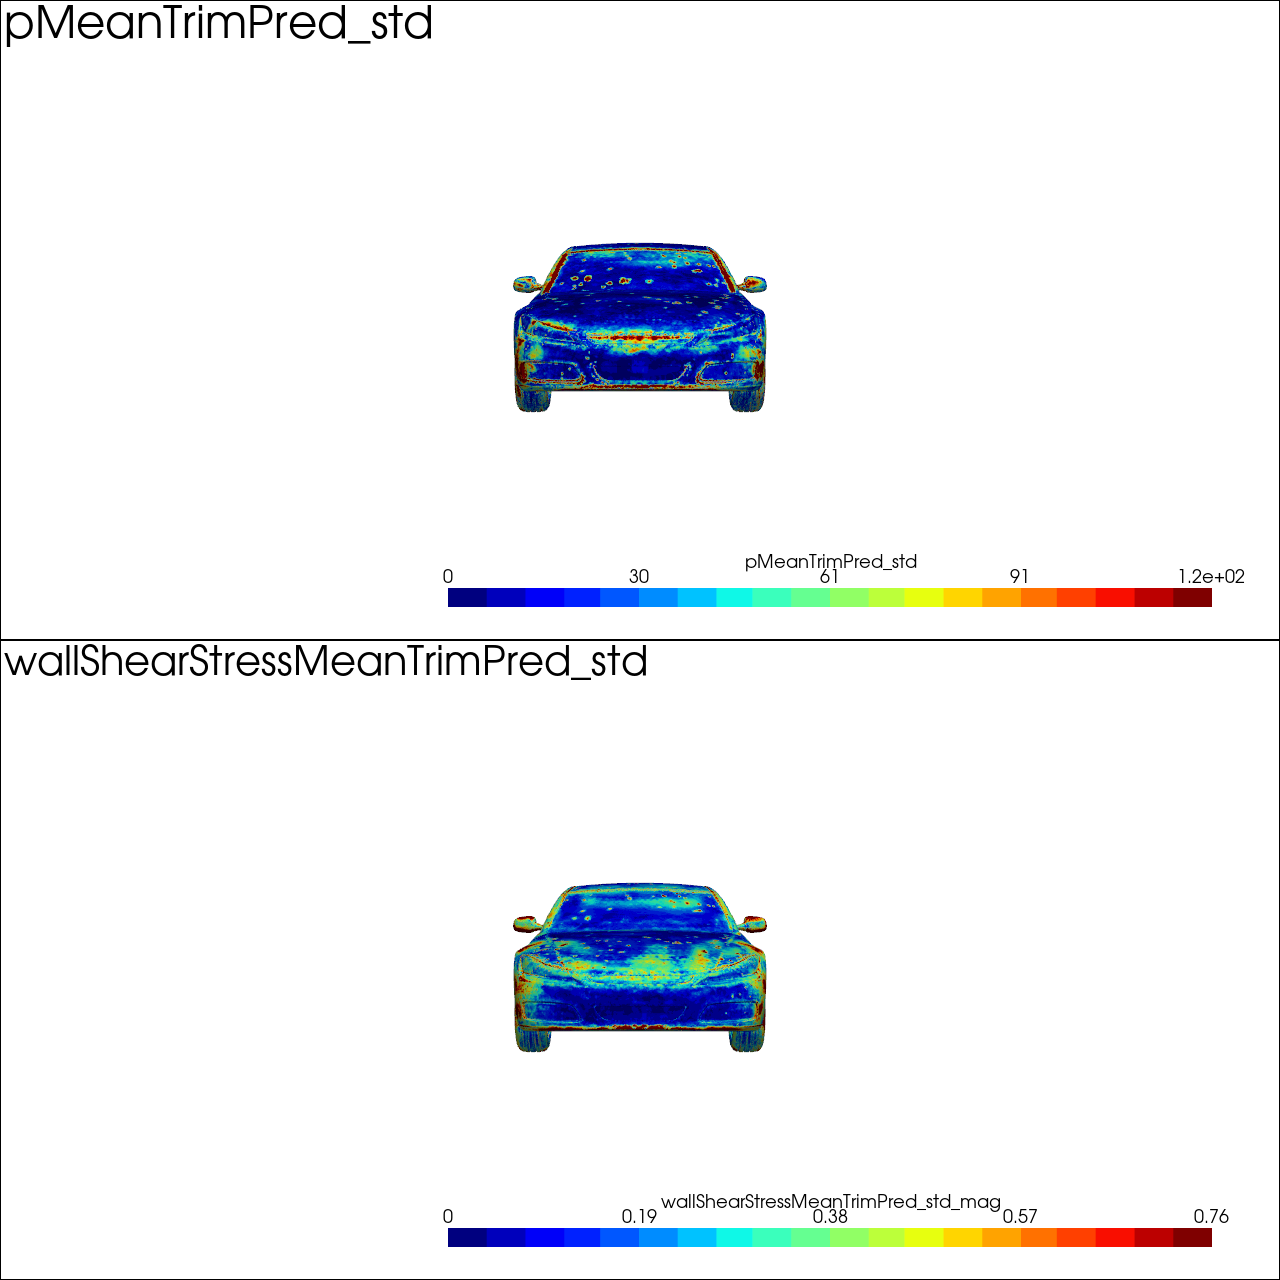

In [ ]:
fields_to_plot = ["pMeanTrimPred_std", "wallShearStressMeanTrimPred_std"]
plotter = plot_std_fields(mesh, 
    fields_to_plot,
    plot_vector_components=False,
    view="yz",
    view_negative=True,
    dtype="cell",
    cmap="jet",
    lut=20,
    window_size=[1280, 1280],
)

filename = "outputs/plots/variations_with_mesh_yz.png"  

plotter.screenshot(filename)

Image(filename=filename)

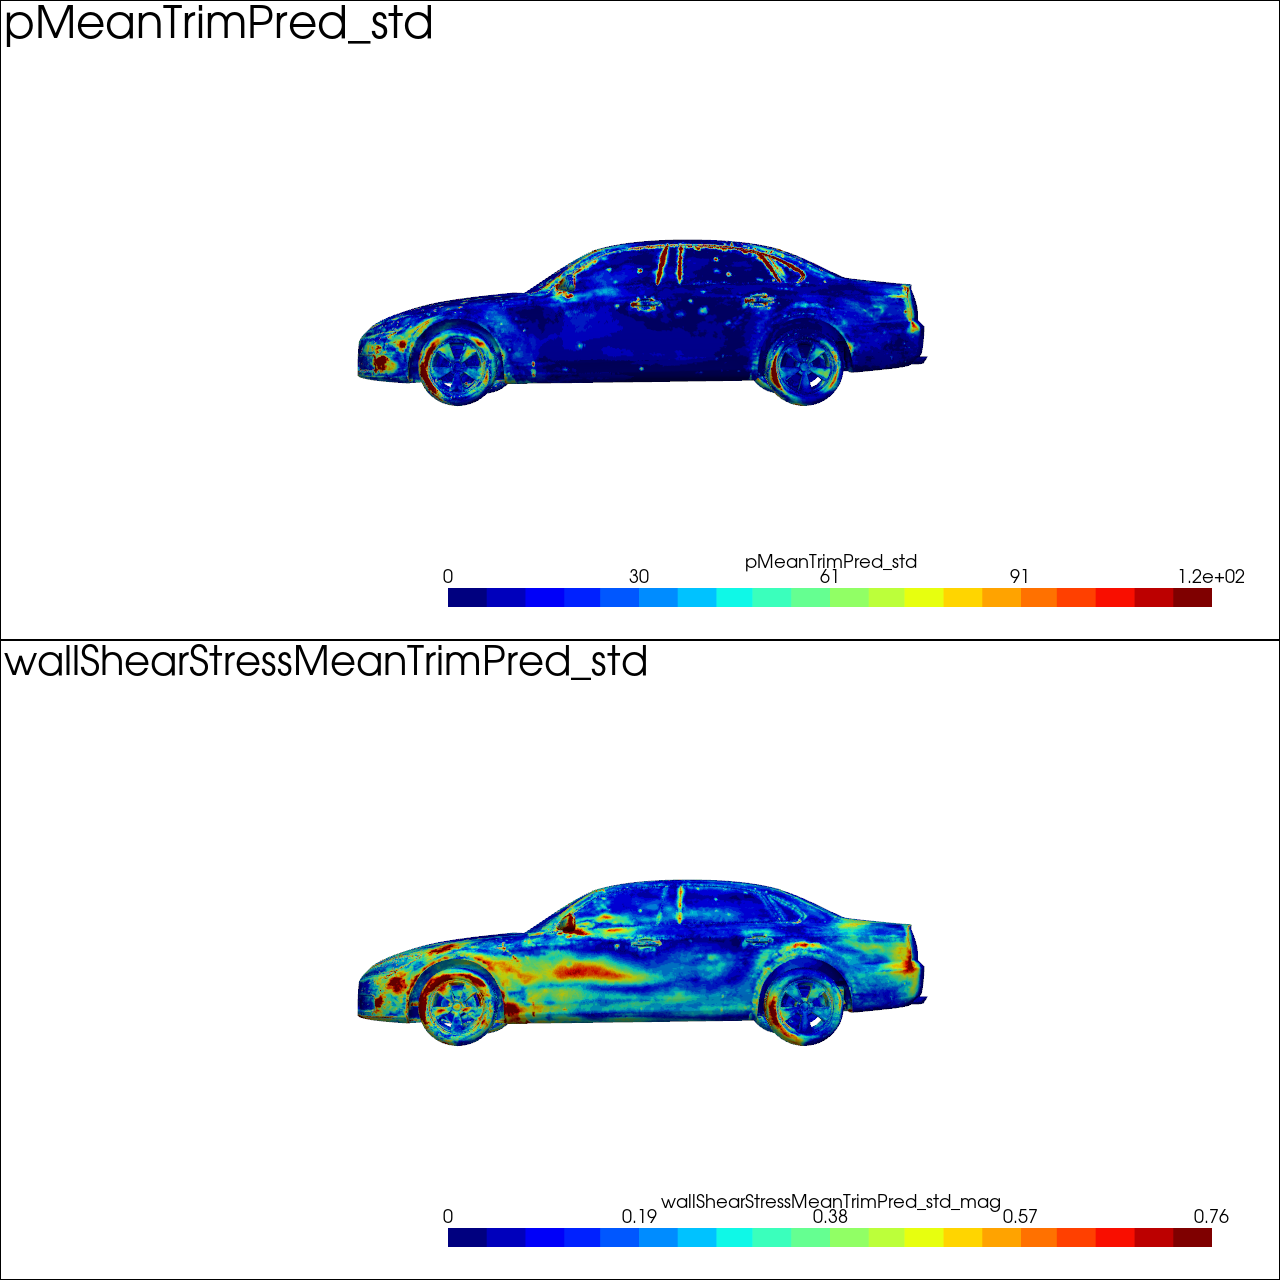

In [ ]:
fields_to_plot = ["pMeanTrimPred_std", "wallShearStressMeanTrimPred_std"]
plotter = plot_std_fields(mesh, 
    fields_to_plot,
    plot_vector_components=False,
    view="xz",
    view_negative=False,
    dtype="cell",
    cmap="jet",
    lut=20,
    window_size=[1280, 1280],
)

filename = "outputs/plots/variations_with_mesh_xz.png"

plotter.screenshot(filename)

Image(filename=filename)

We can observe that just by changing the input STL resolution/remeshing, the predictions of the model change. The fields show a high variance near the edges, which is expected, as that is where the mesh changes affect the topology. However, in addition to the edges, the model results also show high variance in areas where the topology does not change much, for example, some areas of the roof, wheels, and the sides of the car. 

## Bonus: Computing the Equation Residuals

Continuity and the Momentum Equations (Navier-Stokes) are the fundamental equations that govern the fluid dynamics of the external aero. We can use the library to measure how well the model's results capture the mass and energy balances. We can use the `compute_continuity_residuals` and `compute_momentum_residuals` functions for these.

**NOTE**

Due the the large size of the mesh, this computation can take a few minutes. If you are not interested in the this metric, you can skip the below code blocks. 


In [ ]:
from physicsnemo_cfd.physics import (
    compute_continuity_residuals,
    compute_momentum_residuals,
)

# Let's clip the mesh to work on a smaller dataset
# Set crinkle=True for faster clipping
clipped_mesh = volume_mesh.clip_box(
    bounds=[-2, 6, -0.20, 0.20, -0.32, 3.00],
    invert=False,
    progress_bar=True,
    merge_points=False,
    crinkle=True,
)

# Compute continuity
clipped_mesh = compute_continuity_residuals(
    clipped_mesh,
    true_velocity_field="UMeanTrim",
    predicted_velocity_field="UMeanTrimPred",
)

# Optionally, compute momentum using RANS equations
nu = 1.507e-5
rho = 1.0
clipped_mesh = compute_momentum_residuals(
    clipped_mesh,
    true_velocity_field="UMeanTrim",
    predicted_velocity_field="UMeanTrimPred",
    true_pressure_field="pMeanTrim",
    predicted_pressure_field="pMeanTrimPred",
    true_nu_field="nutMeanTrim",
    predicted_nu_field="nutMeanTrimPred",
    nu=nu,
    rho=rho,
)

Clipping a Dataset by a Bounding Box: 100%|██████████[03:43<00:00]


Note that the above two functions will create additional fields for `Continuity`, `ContinuityPred`, `Momentum` and `MomentumPred`. The resulting mesh files can be processed as before. For the purposes of this notebook, let's plot the the fields along the mid-y slice. 

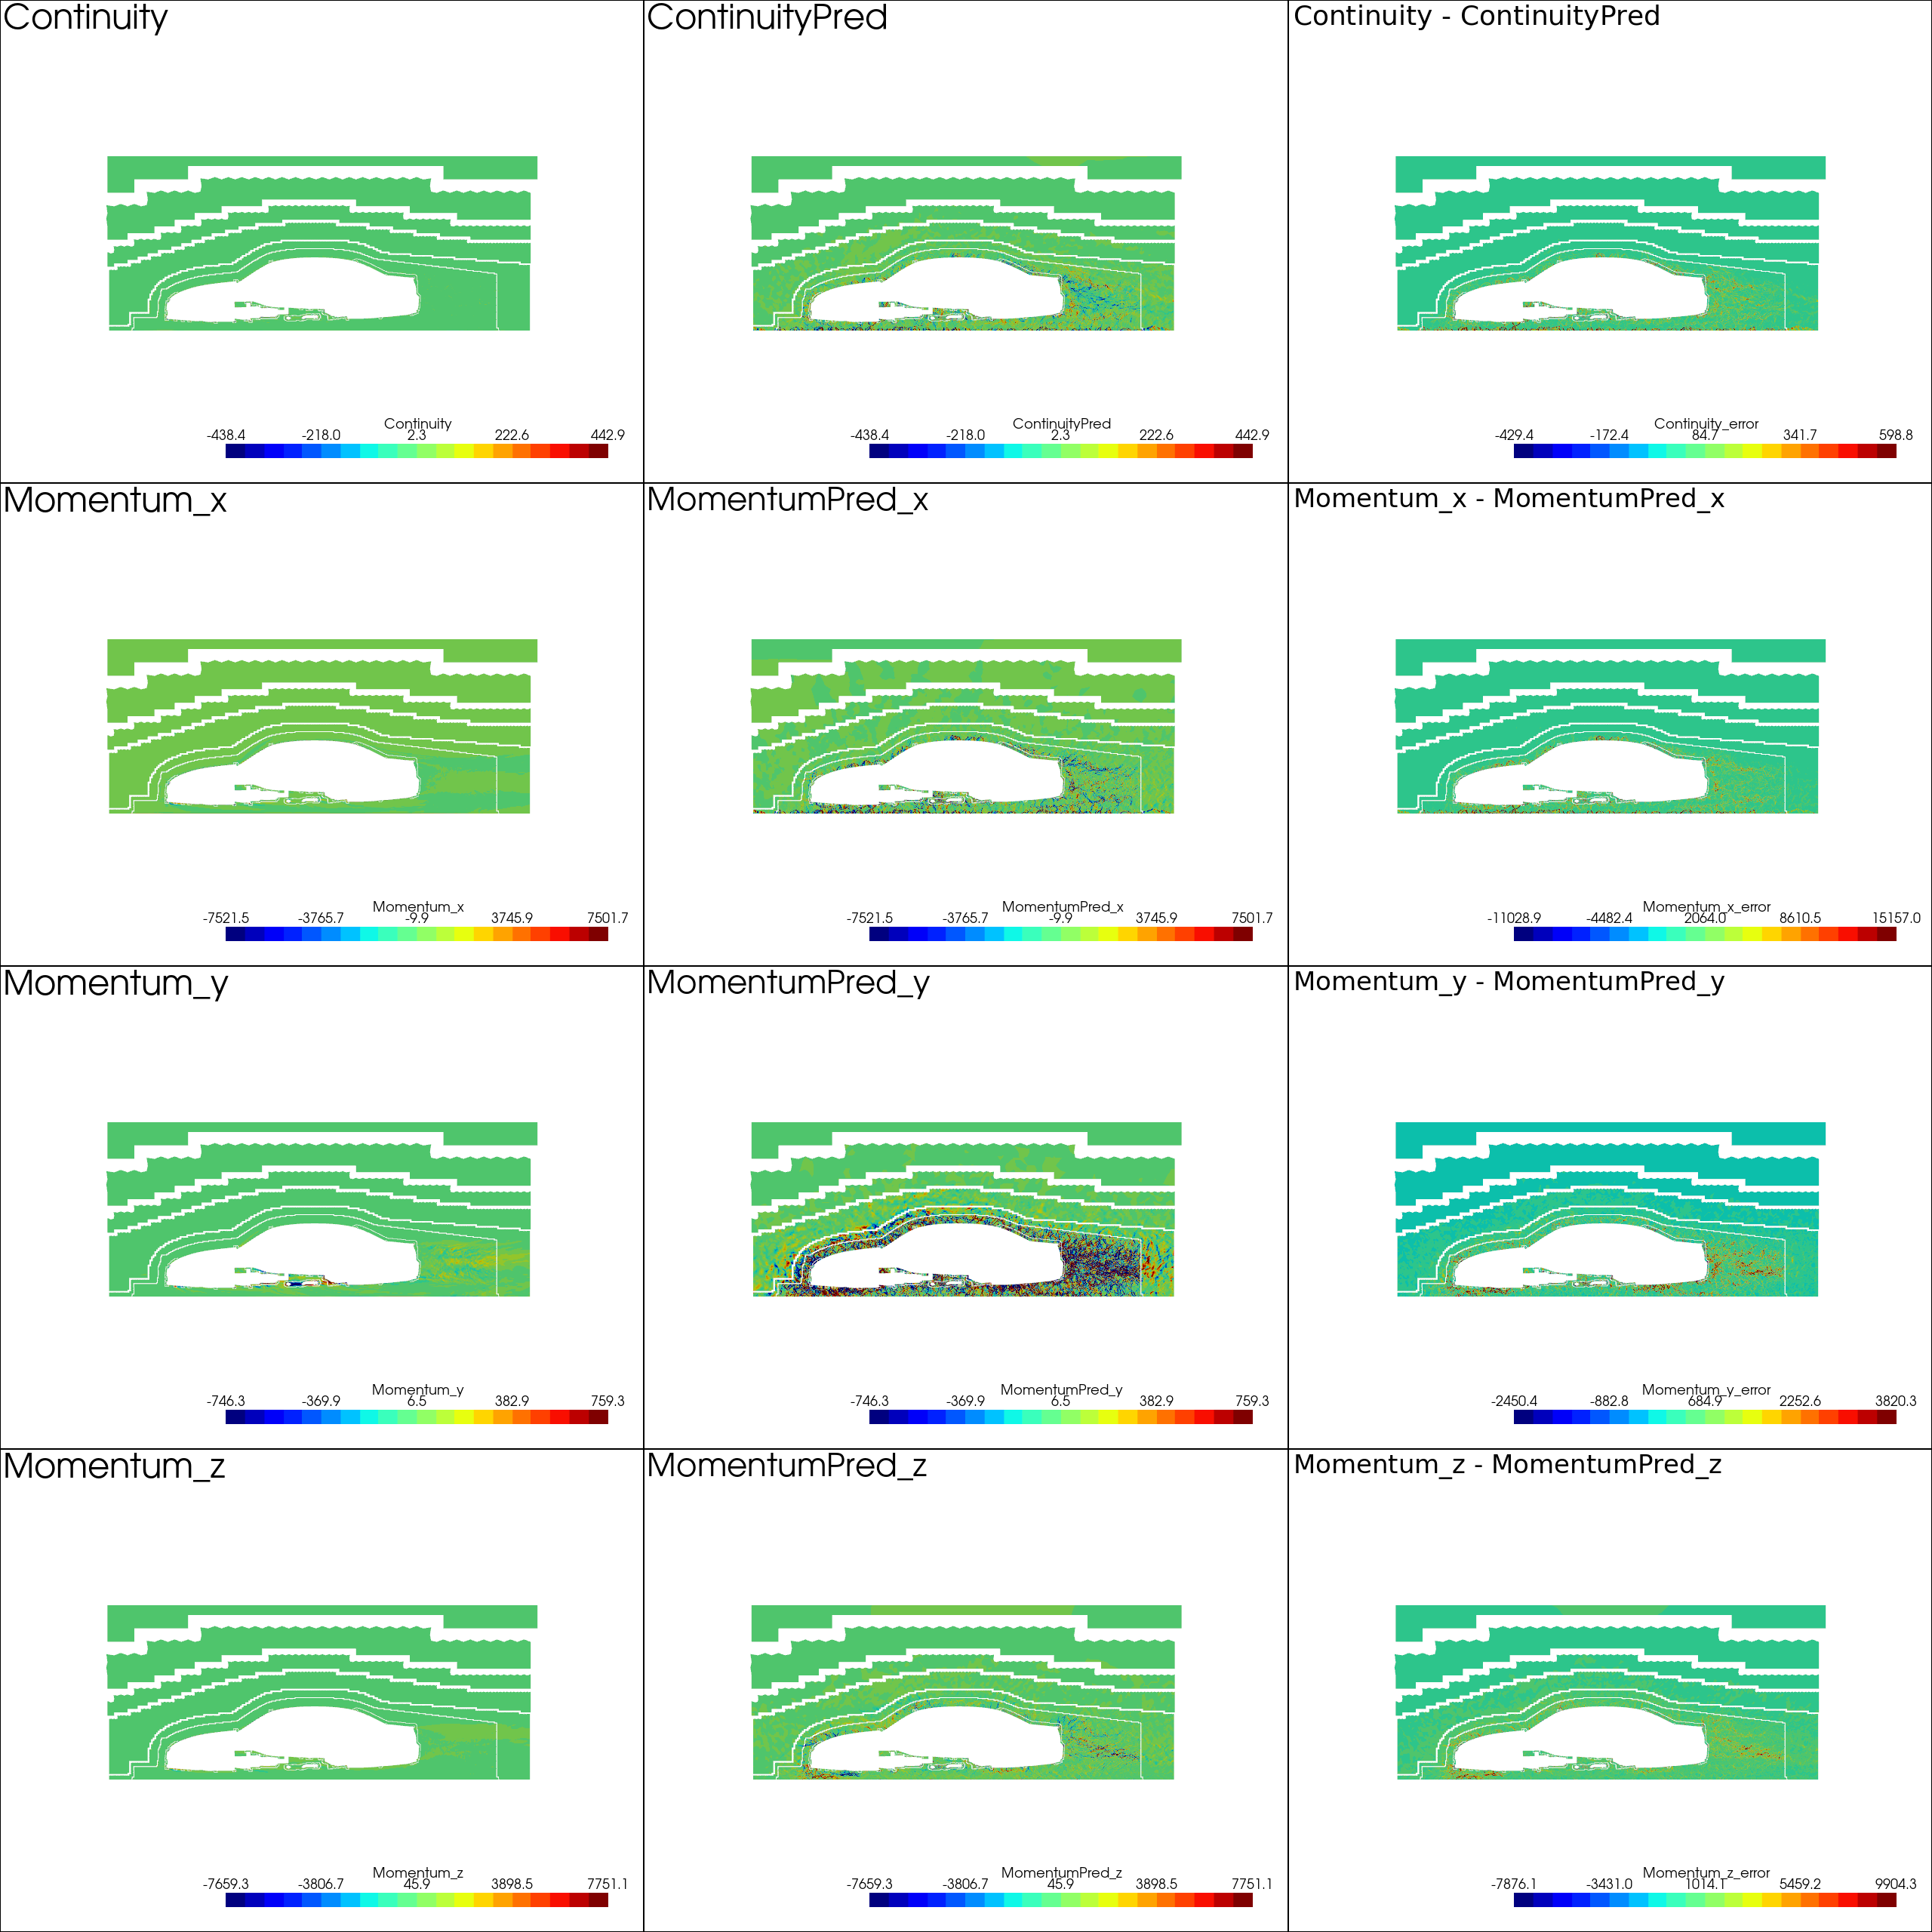

In [ ]:
y_slice = clipped_mesh.slice(normal="y", origin=(0, 0, 0))
y_slice = y_slice.clip_box(bounds, invert=False)

plotter = plot_field_comparisons(
    y_slice,
    true_fields=["Continuity", "Momentum"],
    pred_fields=["ContinuityPred", "MomentumPred"],
    plot_vector_components=True,
    view="xz",
    dtype="point",
    cmap="jet",
    lut=20,
    window_size=[2560, 2560],
)

filename = "outputs/plots/sample_202_volume_y_slice_residuals_comparison.png"

plotter.screenshot(filename)

Image(filename=filename)

The predicted residuals show good adherence of the model predictions to the governing laws. The residuals are generally seen to be higher in the wake area or the areas of high shear.

We can also compute the residuals in an integral sense. For example, below code demonstrates integral continuity computed on a box surrounding the car.

In [ ]:
from physicsnemo.metrics.cae.integral import surface_integral
from physicsnemo_cfd.physics import interpolate_mesh_to_pc

# Define a box smaller than the overall bounding box
integral_box_bounds = [-2, 5, -1.5, 1.5, -0.2, 1.5]
integral_box = pv.Box(integral_box_bounds, level=40)
integral_box = interpolate_mesh_to_pc(integral_box, volume_mesh, ["UMeanTrim", "UMeanTrimPred"], mesh_dtype="point")

integrals = surface_integral(integral_box)
integrals

{'integral_UMeanTrim': array([-1.41115921]),
 'integral_UMeanTrimPred': array([18.79682098]),
 'integral_Normals': array([75.99999984])}

 We can observe that the integral continuity (integral U) for the predicted result is further away from 0 compared to the true result. It is quite interesting however to note that even the true solution does not respect the continuity perfectly. 

<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">